## Carga de librerías

In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.6 MB/s eta 0:00:00


In [ ]:
# Solo ejecutar (descomentar) si se va a correr auto arima
#!pip install numpy==1.26.4
#!pip install pmdarima

In [ ]:
# 👉 Instala Librería Rpy2 para ejecutar código de R en entorno python
!pip install -q rpy2==3.5.11

# Cargar la extensión de R en Colab
%load_ext rpy2.ipython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Instala librerías y paquetes del entorno R. Ejecutar solo una vez.
%%R
# Instalar paquetes R necesarios (solo 1ª vez)
install.packages("urca", repos = "https://cloud.r-project.org")
install.packages("uroot", repos="http://cran.us.r-project.org")



(as ‘lib’ is unspecified)







	‘/tmp/RtmpKJpLlZ/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpKJpLlZ/downloaded_packages’



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
import warnings
import itertools
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import gc  # para limpieza de memoria
from pandas.plotting import table

# Suprimir warnings de convergencia y deprecaciones
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=FutureWarning)  # Ocultar FutureWarning de sklearn utils


In [ ]:
# Mostrar **todas** las filas
pd.set_option('display.max_rows', None)

# Mostrar **todas** las columnas
pd.set_option('display.max_columns', None)

# Opcional: ajustar anchura máxima de cada columna
pd.set_option('display.max_colwidth', None)

## Funciones y clases comunes:

In [ ]:
# --- Función de Autocovarianza ---

def autocovariance(serie, lag):
    series_mean = np.mean(serie)
    n = len(serie)
    return np.sum((serie[:n-lag] - series_mean) * (serie[lag:] - series_mean)) / n

In [ ]:
# --- Model Classes ---
class BaseModel:
    """Interfaz base: define fit y forecast, y propiedades aic, bic."""
    def fit(self, series):
        raise NotImplementedError
    def forecast(self, horizon):
        raise NotImplementedError
    @property
    def aic(self):
        return np.nan
    @property
    def bic(self):
        return np.nan

class SARIMAModel(BaseModel):
    """Modelo SARIMA usando statsmodels SARIMAX."""
    def __init__(self, order, seasonal_order,
                 enforce_stationarity=True, enforce_invertibility=True):
        self.order = order
        self.seasonal_order = seasonal_order
        self.enforce_stationarity = enforce_stationarity
        self.enforce_invertibility = enforce_invertibility
        self.result = None

    def fit(self, series):
        """Ajusta el modelo SARIMAX a la serie dada."""
        model = SARIMAX(
            series,
            order=self.order,
            seasonal_order=self.seasonal_order,
            enforce_stationarity=self.enforce_stationarity,
            enforce_invertibility=self.enforce_invertibility
        )
        self.result = model.fit(disp=False)
        return self

    def forecast(self, horizon):
        """Pronostica los siguientes `horizon` pasos."""
        return self.result.get_forecast(steps=horizon).predicted_mean.values

    @property
    def aic(self):
        return self.result.aic

    @property
    def bic(self):
        return self.result.bic

class NaiveModel(BaseModel):
    """Baseline naive: repite el último valor conocido."""
    def __init__(self):
        self.last = None

    def fit(self, series):
        self.last = series.iloc[-1]
        return self

    def forecast(self, horizon):
        return np.full(horizon, self.last)

In [ ]:
# --- Función genérica de CV usando clases ---
def cross_validate_model(
    ModelClass,
    model_kwargs,
    series,
    horizon=10,
    folds=10,
    step=10,
    debug=False
):
    """
    Validación cruzada de ventana creciente parametrizable usando clases.
    Retorna promedios de rmse, mae, mape, aic y bic.
    """
    data = series.dropna().reset_index(drop=True)
    n = len(data)
    # Calcular el primer punto de corte
    start_point = n - horizon - step * (folds -1)

    rmses, maes, mapes, aics, bics = [], [], [], [], []
    fold_count = 0
    # Iterar sobre los mismos puntos de corte que el SARIMA original
    for end_train in range(start_point, n -horizon+1, step):
        fold_count += 1
        train = data.iloc[:end_train]
        test = data.iloc[end_train:end_train + horizon]
        if debug:
            print(f"Fold {fold_count}: train[0:{end_train}], test[{end_train}:{end_train+horizon}]")

        # Instanciar y ajustar el modelo
        model = ModelClass(**model_kwargs) if model_kwargs else ModelClass()
        try:
            model.fit(train)
        except Exception as e:
            if debug:
                print(f"  Error al ajustar modelo: {e}")
            return {'rmse': np.inf, 'mae': np.inf, 'mape': np.inf, 'aic': np.inf, 'bic': np.inf}

        # Pronóstico
        y_pred = model.forecast(horizon)
        y_true = test.values

        # Calcular métricas
        rmses.append(np.sqrt(mean_squared_error(y_true, y_pred)))
        maes.append(mean_absolute_error(y_true, y_pred))
        mapes.append(mape(y_true, y_pred))
        aics.append(model.aic)
        bics.append(model.bic)

        if debug:
            print(f"  Metrics fold {fold_count}: RMSE={rmses[-1]:.4f}, MAE={maes[-1]:.4f}, MAPE={mapes[-1]:.2f}")
        # Detener si alcanzamos 'folds' iteraciones
        if fold_count >= folds:
            break

    # Promediar y devolver resultados
    return {
        'rmse': np.mean(rmses),
        'mae':  np.mean(maes),
        'mape': np.mean(mapes),
        'aic':  np.mean(aics),
        'bic':  np.mean(bics)
    }

In [ ]:
# --- Métricas auxiliares ---
def mape(y_true, y_pred):
    """Mean Absolute Percentage Error, ignorando valores cero en y_true."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if not np.any(mask):
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [ ]:
# Variables CV y predicción
horizon = 10
folds = 10
step = 10

In [ ]:
# Parámetros de los mejores modelos de SARIMA encontrados. Si se cambiase algún parámetro de búsqueda y se encuentran otros modelos, esto debería cambiarse.
# Son los modelos donde se mide la performance en el test, se hace el análisis diagnóstico, las predicciones en el futuro y el SARIMAX.
sarima_models_params = {
    "SP500":  {
        "order": (2, 0, 2),
        "seasonal_order": (0, 1, 0, 5)
    },
    "Spread_10y_2y": {
        "order": (2, 0, 1),
        "seasonal_order": (2, 1, 1, 5)
    },
    "VIX":    {
        "order": (2, 1, 1),
        "seasonal_order": (0, 0, 1, 5)
    },
}





In [ ]:
# Parámetros de los mejores modelos de SARIMAX Elegido a las series Spread10y_2y y VIX + SP500 diff encontrados.
#Si se cambiase algún parámetro de búsqueda y se encuentran otros modelos, esto debería cambiarse.
# Son los modelos donde se mide la performance en el test, se hace el análisis diagnóstico, las predicciones en el futuro y el SARIMAX.


sarimax_best_order = (0, 1, 0)
sarimax_best_seasonal_order = (2, 0, 1, 5)

## Con el fin de optimizar los tiempos de ejecución se realizan los siguientes cambios en el código:


*   Los GridSearch para hiperparámetros se comentan
*   Los Modelos, tanto el SARIMA como el SARIMAX, se entrenan con los parámetros hallados mediante corridas de gridsearch



## Carga y preparación de datos

In [ ]:
GS10_GS2 = pd.read_csv('https://raw.githubusercontent.com/HGalletti/Series-temporales/main/GS10_GS2_Daily.csv',
                       sep=';',
                       skiprows=1, # Salteamos el encabezado para poder indicarle el tipo float al resto. Si no indicamos el tipo float, lo autodetecta como object.
                       index_col=0,
                       names=["Fecha", "GS10", "GS2", "Spread_10y_2y"],
                       parse_dates=["Fecha"],
                       date_format="%d/%m/%Y",
                       dtype={
                        "GS10": "float",
                        "GS2": "float",
                        "Spread_10y_2y": "float"
                        })
# Nos quedamos con las columnas que trabajaremos
GS10_GS2 = GS10_GS2[['Spread_10y_2y']]
GS10_GS2 = GS10_GS2.loc['2000-01-03':] # Hay datos desde '1976-06-01'

In [ ]:
columns = ["Fecha", "Close", "High", "Low", "Open", "Volume"]

sp500 = pd.read_csv(
    'https://raw.githubusercontent.com/HGalletti/Series-temporales/main/SP500_diario_2000-2025.csv',
    sep=',',
    skiprows=3,          # ❌ saltamos las 3 primeras líneas basura
    header=None,         # 🚫 no hay encabezado útil
    names=columns,       # ✅ asignamos nombres de columnas
    index_col=0          # 🏷️ temporalmente usamos la columna 0 ("Fecha") como índice
)



vix = pd.read_csv(
    'https://raw.githubusercontent.com/HGalletti/Series-temporales/main/VIX_diario_2000-2025.csv',
    sep=',',
    skiprows=3,          # ❌ saltamos las 3 primeras líneas basura
    header=None,         # 🚫 no hay encabezado útil
    names=columns,       # ✅ asignamos nombres de columnas
    index_col=0          # 🏷️ temporalmente usamos la columna 0 ("Fecha") como índice
)

# Seteamos los índices en formato fecha
sp500.index = pd.to_datetime(sp500.index)
vix.index = pd.to_datetime(vix.index)

# Ahora nos quedamos con la columna "Close" de ambos
sp500 = sp500[["Close"]]
vix = vix[["Close"]]



In [ ]:
# Joineamos las tres series
series = pd.concat([GS10_GS2, sp500, vix], axis=1, join='outer')
series.columns = ['Spread_10y_2y', 'SP500', 'VIX']

In [ ]:
series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6650 entries, 2000-01-03 to 2025-06-27
Freq: B
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Spread_10y_2y  6374 non-null   float64
 1   SP500          6410 non-null   float64
 2   VIX            6410 non-null   float64
dtypes: float64(3)
memory usage: 207.8 KB


In [ ]:
series[
    series["Spread_10y_2y"].isna() &
    series["SP500"].notna() &
    series["VIX"].notna()
]


,Spread_10y_2y,SP500,VIX
Fecha,,,
2000-10-09,NaN,1402.030029,24.020000
2001-10-08,NaN,1062.439941,35.119999
2001-11-12,NaN,1118.329956,29.350000
2002-10-14,NaN,841.440002,36.040001
2002-11-11,NaN,876.190002,31.299999
2003-10-13,NaN,1045.349976,17.549999
2003-11-11,NaN,1046.569946,17.540001
2004-10-11,NaN,1124.390015,14.710000
2004-11-11,NaN,1173.479980,13.040000


Las fechas faltantes en los bonos parece que corresponden a feriados del mercado de bonos: https://www.sifma.org/wp-content/uploads/2017/06/misc-us-historical-holiday-market-recommendations-sifma.pdf

In [ ]:
# Asegura que las fechas estén ordenadas antes de establecer frecuencia y rellenar valores faltantes
series = series.sort_index().asfreq("B")  # genera índice regular y mete NaNs si faltan fechas
series = series.ffill()                   # rellena todos los NaNs, incluso los ya existentes


In [ ]:
series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6650 entries, 2000-01-03 to 2025-06-27
Freq: B
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Spread_10y_2y  6650 non-null   float64
 1   SP500          6650 non-null   float64
 2   VIX            6650 non-null   float64
dtypes: float64(3)
memory usage: 207.8 KB


In [ ]:
series.head()

,Spread_10y_2y,SP500,VIX
Fecha,,,
2000-01-03,0.20,1455.219971,24.209999
2000-01-04,0.19,1399.420044,27.010000
2000-01-05,0.24,1402.109985,26.410000
2000-01-06,0.22,1403.449951,25.730000
2000-01-07,0.21,1441.469971,21.719999


In [ ]:
# Didividmos en training y test
series_train = series.iloc[:-horizon]
series_test = series.iloc[-horizon:]

## Gráficas, descomposición y autocorrelaciones

### Gráficas de las series

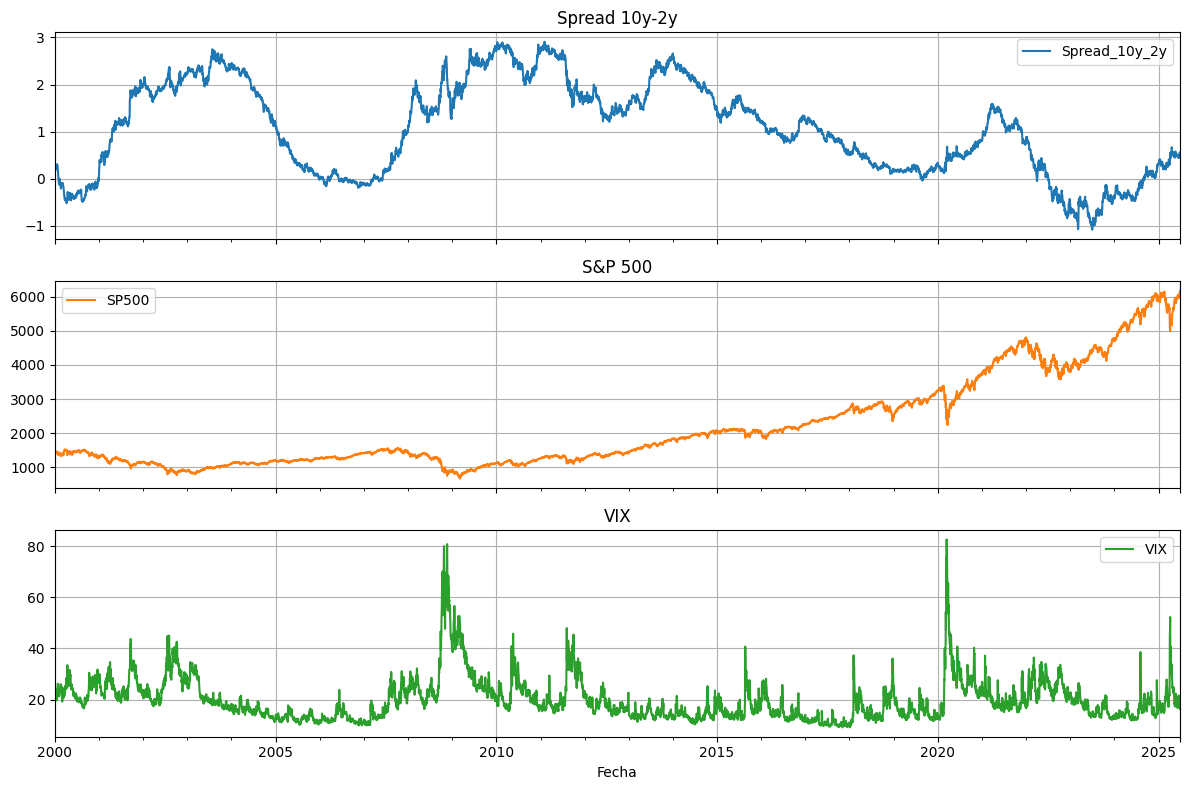

In [ ]:
series[["Spread_10y_2y", "SP500", "VIX"]].plot(
    subplots=True,
    layout=(3, 1),
    figsize=(12, 8),
    sharex=True,
    title=["Spread 10y-2y", "S&P 500", "VIX"],
    grid=True
)

plt.tight_layout()
plt.show()

### Descomposición en componentes

Descomponemos las series en sus componentes

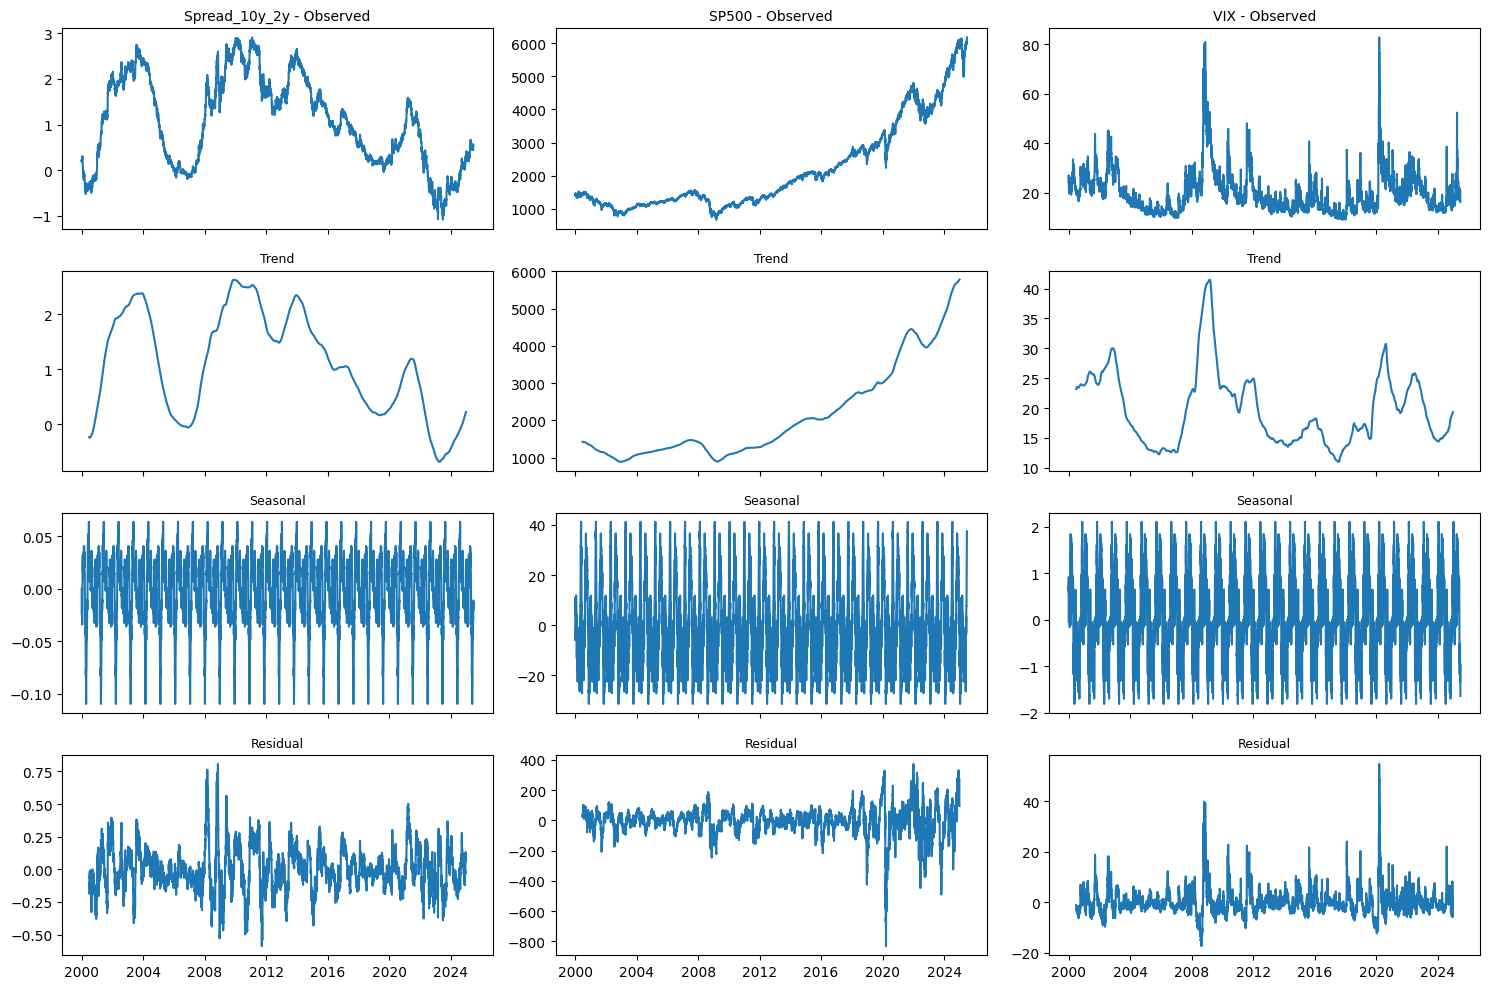

In [ ]:
# Descomponemos aditivamente, multiplicativamente no se puede con el spread pues toma valores negativos
# Elegí las 3 series que quieras mostrar
series_to_plot = ['Spread_10y_2y', 'SP500', 'VIX']

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10), sharex='col')
axes = axes  # acceso tipo axes[fila][columna]

for j, col in enumerate(series_to_plot):
    result = seasonal_decompose(series[col], model='additive', period=252)

    axes[0, j].plot(result.observed)
    axes[0, j].set_title(f"{col} - Observed", fontsize=10)

    axes[1, j].plot(result.trend)
    axes[1, j].set_title("Trend", fontsize=9)

    axes[2, j].plot(result.seasonal)
    axes[2, j].set_title("Seasonal", fontsize=9)

    axes[3, j].plot(result.resid)
    axes[3, j].set_title("Residual", fontsize=9)

# Ajustes generales
plt.tight_layout()
plt.show()



- El índice SP500 claramente no es estacionario pues la linea de tendencia crece sostenidamente salvo algunas caidas relativamente breves.
- El VIX no tiene una tendencia monótona ni una varianza creciente sostenida, pero no cumple estrictamente con la condición de varianza constante, ya que tiene los residuos tienen saltos irregulares de alta volatilidad en momentos de crisis.
- El Spread parece tener algunos de los saltos irregulares de residuo que el VIX, pero es menos claro. Posiblemente no sea del todo estacionaria.

### Funciones de Autocorrelación en Series Temporales

#### Función de Autocorrelación Simple (FAS o FAC)

La *Función de Autocorrelación Simple (FAS)*, también conocida como *FAC* (Función de Autocorrelación Completa), mide la correlación lineal entre los valores de una serie temporal y sus propios valores rezagados. Para un proceso estacionario $\{Y_t\}$, la autocorrelación en el rezago $k$ se define como:

$$
\rho_k = \frac{\text{Cov}(Y_t, Y_{t-k})}{\text{Var}(Y_t)} = \frac{\mathbb{E}[(Y_t - \mu)(Y_{t-k} - \mu)]}{\sigma^2}
$$

Esta función ayuda a detectar patrones de dependencia temporal. Su gráfico, conocido como *correlograma*, muestra cómo se comporta la correlación a medida que aumenta el rezago $k$.

---

#### Función de Autocorrelación Parcial (FACP)

La *Función de Autocorrelación Parcial (FACP)* mide la correlación entre $ Y_t $ y $ Y_{t-k} $, eliminando los efectos lineales de los valores intermedios $ Y_{t-1}, Y_{t-2}, \dots, Y_{t-k+1} $.

Más concretamente:

$$
\phi_{kk} = \text{Corr}(Y_t, Y_{t-k} \mid Y_{t-1}, Y_{t-2}, \dots, Y_{t-k+1})
$$

Esta cantidad representa la *correlación condicional* entre $ Y_t $ y $ Y_{t-k} $, dado el conocimiento de los rezagos intermedios. La FACP es especialmente útil para identificar el orden $ p $ de un modelo AR($p$), ya que tiende a cortarse (volverse no significativa) a partir del rezago $ p+1 $.

El gráfico de la FACP es útil para identificar el orden $p$ de un posible modelo autorregresivo AR($p$), ya que típicamente se corta después del rezago $p$ en procesos AR puros.


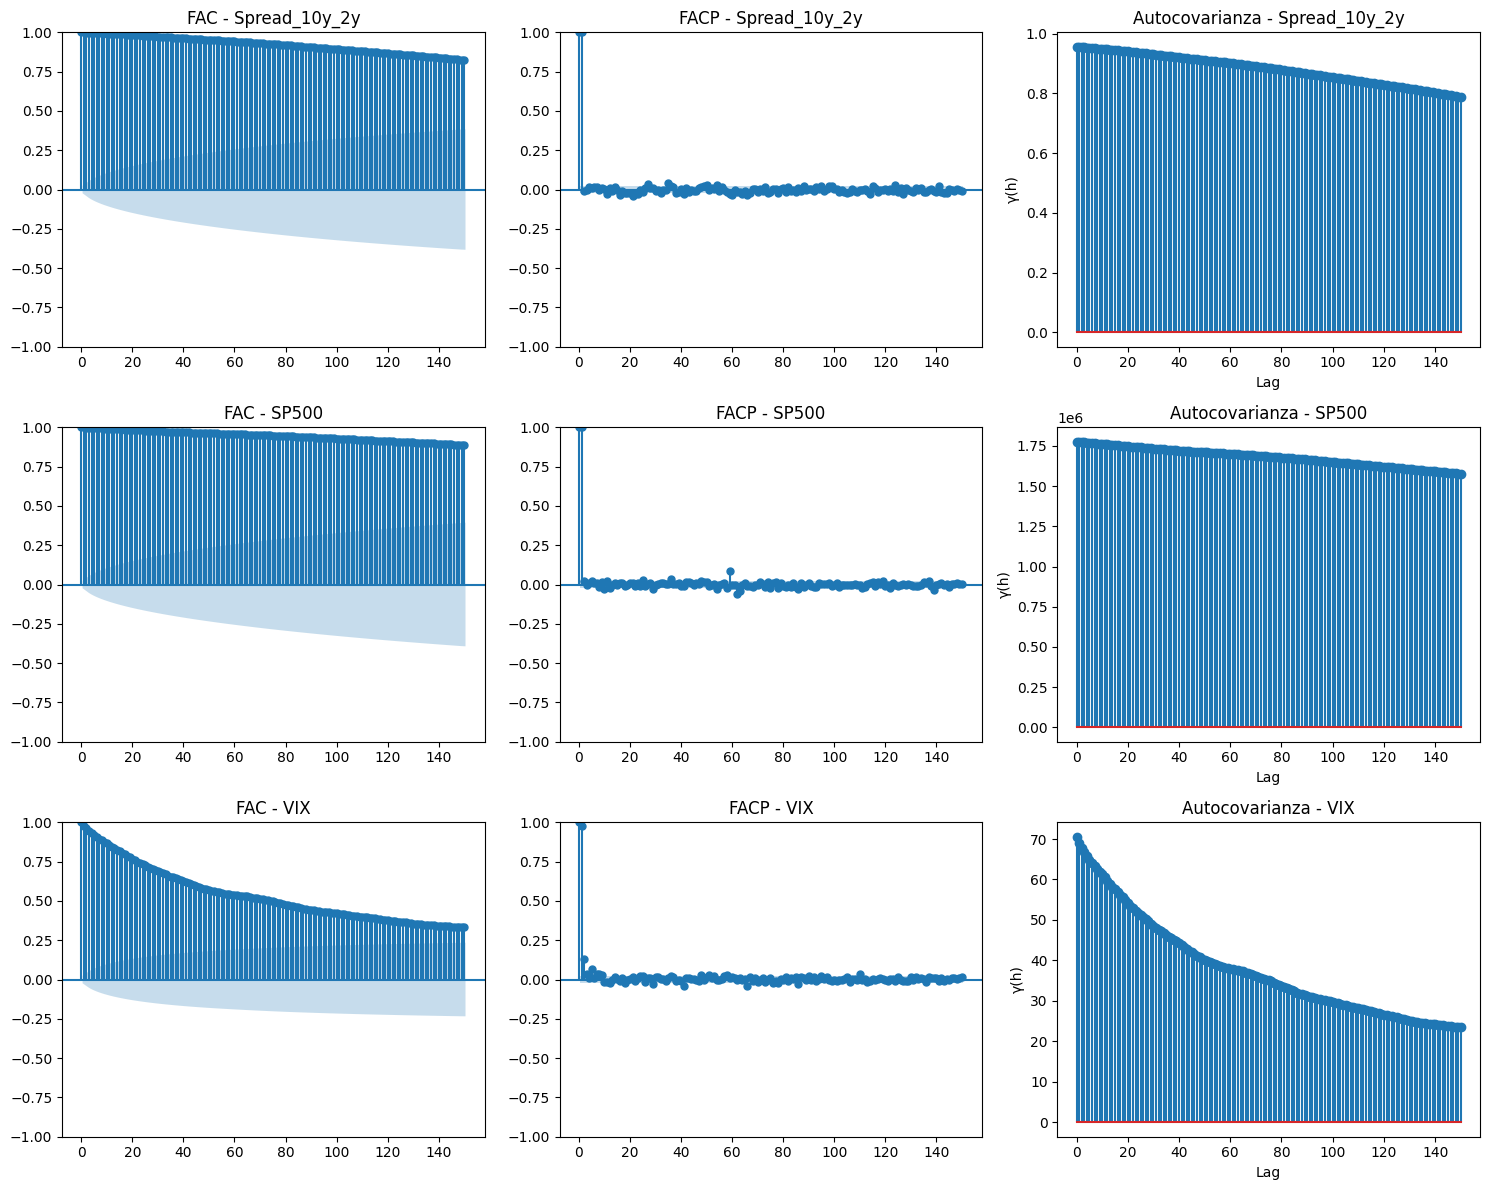

In [ ]:
# Crear figura con 3 filas (una por serie) y 3 columnas (FAC, FACP, Autocovarianza)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
series_names = ['Spread_10y_2y', 'SP500', 'VIX']
lags=150

for i, col in enumerate(series_names):
    data = series[col].dropna()

    # FAC
    plot_acf(data, ax=axes[i, 0], lags=lags)
    axes[i, 0].set_title(f'FAC - {col}')

    # FACP
    plot_pacf(data, ax=axes[i, 1], lags=lags, method='ywm')
    axes[i, 1].set_title(f'FACP - {col}')

    # AUTOCOVARIANZA
    autocovs = [autocovariance(data.values, lag) for lag in range(lags + 1)]
    axes[i, 2].stem(range(lags + 1), autocovs)
    axes[i, 2].set_title(f'Autocovarianza - {col}')
    axes[i, 2].set_xlabel("Lag")
    axes[i, 2].set_ylabel("γ(h)")

plt.tight_layout()
plt.show()

Se observa que en los tres casos la FAC no decrece rápidamente hacia cero. En las dos primeras series, el comportamiento presenta un patrón de decrecimiento aproximadamente lineal, mientras que en la tercera, si bien no sigue una línea clara, los coeficientes se mantienen persistentemente distintos de cero en rezagos elevados. Esto indica que las series no son estacionarias, ya que, según los criterios teóricos, un proceso estacionario debería mostrar una autocorrelación que se desvanece rápidamente, usualmente de forma exponencial.

## Análisis de Raíces

### Raíces unitarias y estacionariedad

En el análisis de series temporales, una propiedad fundamental es la estacionariedad. Una serie es estrictamente estacionaria si su distribución conjunta no cambia con el tiempo. Sin embargo, en la práctica trabajamos con el concepto más débil de estacionariedad en sentido débil o débilmente estacionaria, que se refiere a que la media, la varianza y la covarianza se mantienen constantes en el tiempo.

Una serie no estacionaria puede presentar:


*   Tendencia creciente o decreciente
*   Varianza no constante
*   Estacionalidad (patrones que se repiten en intervalos regulares)



Cuando una serie no es estacionaria porque tiene una raíz unitaria, significa que sus valores dependen fuertemente de su pasado, y que los efectos de un shock (evento externo) no se disipan con el tiempo.

Existen varias pruebas estadísticas para determinar si una serie tiene raíz unitaria:


1. ADF (Augmented Dickey-Fuller)
Hipótesis nula
𝐻
0
H
0
​
 : la serie tiene raíz unitaria (no es estacionaria)

Hipótesis alternativa
𝐻
1
H
1
​
 : la serie es estacionaria

Si el p-valor < 0.05, se rechaza
𝐻
0
H
0
​
  → la serie es estacionaria




---




2. KPSS (Kwiatkowski-Phillips-Schmidt-Shin)
Hipótesis nula
𝐻
0
H
0
​
 : la serie es estacionaria

Hipótesis alternativa
𝐻
1
H
1
​
 : la serie tiene raíz unitaria (no es estacionaria)

Si el p-valor < 0.05, se rechaza
𝐻
0
H
0
​
  → la serie no es estacionaria

A diferencia del ADF, en la KPSS la estacionariedad es la hipótesis nula, por lo tanto ambas pruebas se complementan.




---




3. Phillips-Perron (PP)
Similar al ADF, pero ajusta errores estándar para permitir correlación serial y heterocedasticidad.

Hipótesis nula
H
0
​
 : la serie tiene raíz unitaria

 ---

Entonces:
 Si varias pruebas coinciden en que la serie no es estacionaria, se puede aplicar diferenciación (primera o estacional) para transformarla en estacionaria. Luego, se pueden modelar con ARIMA o SARIMA.

In [ ]:
## Cargamos una función para realizar el análisis sobre cada serie

def analiza_serie(serie, nombre=""):

    print(f"\n\n==============================")
    print(f"📊 Análisis de serie: {nombre}")
    print(f"==============================")

    ##ADF
    print("=== Prueba de Dickey-Fuller Aumentada (ADF) ===")
    adf_result = adfuller(serie)
    print(f"Estadístico ADF: {adf_result[0]:.4f}")
    print(f"P-valor: {adf_result[1]:.4f}")
    for key, value in adf_result[4].items():
        print(f"Valor crítico {key}: {value:.4f}")
    if adf_result[1] < 0.05:
        print("➤ Rechazamos H₀: la serie es estacionaria.")
    else:
        print("➤ No se puede rechazar H₀: la serie tiene raíz unitaria (no es estacionaria).")

    ##KPSS
    print("\n=== Prueba KPSS ===")
    kpss_stat, kpss_pval, _, kpss_crit = kpss(serie, regression='c')
    print(f"Estadístico KPSS: {kpss_stat:.4f}")
    print(f"P-valor: {kpss_pval:.4f}")
    for key, value in kpss_crit.items():
        print(f"Valor crítico {key}: {value}")
    if kpss_pval < 0.05:
        print("➤ Rechazamos H₀: la serie NO es estacionaria.")
    else:
        print("➤ No se puede rechazar H₀: la serie es estacionaria.")

    ##PP
    print("\n=== Prueba Phillips-Perron (PP) ===")
    pp_result = PhillipsPerron(serie)
    print(pp_result.summary())

In [ ]:
## Analizamos las series

for col in series.columns:
    analiza_serie(series[col], nombre=col)



📊 Análisis de serie: Spread_10y_2y
=== Prueba de Dickey-Fuller Aumentada (ADF) ===
Estadístico ADF: -1.8848
P-valor: 0.3393
Valor crítico 1%: -3.4313
Valor crítico 5%: -2.8620
Valor crítico 10%: -2.5670
➤ No se puede rechazar H₀: la serie tiene raíz unitaria (no es estacionaria).

=== Prueba KPSS ===
Estadístico KPSS: 2.8839
P-valor: 0.0100
Valor crítico 10%: 0.347
Valor crítico 5%: 0.463
Valor crítico 2.5%: 0.574
Valor crítico 1%: 0.739
➤ Rechazamos H₀: la serie NO es estacionaria.

=== Prueba Phillips-Perron (PP) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.743
P-value                         0.409
Lags                               35
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


📊 Análisis de serie: SP500
=== Prueba de Dickey-Fuller Aumentada (ADF) ===
Estadístico ADF: 2.3104
P-v

Se aplicaron tres pruebas estadísticas (ADF, KPSS y Phillips-Perron) a cada una de las series analizadas: Spread_10y_2y, SP500 y VIX, con el objetivo de determinar si presentan raíz unitaria, es decir, si son o no estacionarias con los siguientes resultados:

1. Serie: VIX

Prueba ADF:	Tiene un p-valor = 0.0000	por ende se rechaza H₀ → estacionaria

Prueba KPSS: Tiene un	p-valor = 0.0184 por ende se	rechaza H₀ → no estacionaria

Prueba Phillips-Perron Tiene un	p-valor = 0.000 por ende se rechaza H₀ → estacionaria

Dado que dos de los tres test realizados concluyen que la serie puede ser estacionaria, concluimos que es estacionaria

---

2. Serie: Spread 10y-2y

Prueba ADF: Tiene un p-valor = 0.3393 por ende no rechaza H₀ → no estacionaria

Prueba KPSS: Tiene un	p-valor = 0.0100 por ende rechaza H₀ → no estacionaria

Prueba Phillips-Perron: Tiene un p-valor = 0.409 por ende no rechaza H₀ → no estacionaria


Las tres pruebas coinciden en que la serie no es estacionaria.



---

3. Serie: S&P 500

Prueba ADF: Tiene un	p-valor = 0.9990 por ende	no rechaza H₀ → no estacionaria

Prueba KPSS: Tiene un	p-valor = 0.0100 por ende	rechaza H₀ → no estacionaria

Prueba Phillips-Perron: Tiene un p-valor = 0.999 por ende no rechaza H₀ → no estacionaria

Todas las pruebas indican que la serie S&P 500 no es estacionaria.



---



Como conclusión de la aplicación de los distintos test, las series S&P 500 y Spread 10y-2y son no estacionarias, con lo cual debemos aplicar algún criterio de diferenciación para transformarlas y que sean aptas para modelar con SARIMA.


## Aplicamos diferenciación sobre las series no estacionarias

In [ ]:
# Preparamos una copia de las series a diferenciar
##series[["Spread_10y_2y", "SP500", "VIX"]]

Spread_10y_2y_diff = series[["Spread_10y_2y"]].copy()
SP500_diff = series[["SP500"]].copy()

SP500_diff["valor_diff"] = SP500_diff['SP500'].diff().dropna()

SP500_diff.head()

SP500_diff = SP500_diff.drop('2000-01-03')
SP500_diff = SP500_diff['valor_diff']
SP500_diff.head()


,valor_diff
Fecha,
2000-01-04,-55.799927
2000-01-05,2.689941
2000-01-06,1.339966
2000-01-07,38.020020
2000-01-10,16.130005


In [ ]:
Spread_10y_2y_diff["valor_diff"] = Spread_10y_2y_diff['Spread_10y_2y'].diff().dropna()

Spread_10y_2y_diff.head()
Spread_10y_2y_diff = Spread_10y_2y_diff.drop('2000-01-03')
Spread_10y_2y_diff = Spread_10y_2y_diff["valor_diff"]
Spread_10y_2y_diff.head()

,valor_diff
Fecha,
2000-01-04,-0.01
2000-01-05,0.05
2000-01-06,-0.02
2000-01-07,-0.01
2000-01-10,-0.02


## Con las series diferenciadas, volvemos a realizar el test de raíces unitarias

In [ ]:
# Joineamos las tres series: dos diferenciadas y una original
series_diff = pd.concat([Spread_10y_2y_diff, SP500_diff, series[["VIX"]]], axis=1, join='outer')
series_diff.columns = ['Spread_10y_2y_diff', 'SP500_diff', 'VIX']

series_diff = series_diff.drop('2000-01-03')

print(series_diff.head(30))

            Spread_10y_2y_diff  SP500_diff        VIX
Fecha                                                
2000-01-04               -0.01  -55.799927  27.010000
2000-01-05                0.05    2.689941  26.410000
2000-01-06               -0.02    1.339966  25.730000
2000-01-07               -0.01   38.020020  21.719999
2000-01-10               -0.02   16.130005  21.709999
2000-01-11                0.03  -19.039917  22.500000
2000-01-12                0.01   -6.310059  22.840000
2000-01-13                0.00   17.430054  21.709999
2000-01-14                0.02   15.469971  19.660000
2000-01-17                0.00    0.000000  19.660000
2000-01-18                0.03  -10.010010  21.500000
2000-01-19               -0.01    0.760010  21.719999
2000-01-20                0.03  -10.330078  21.750000
2000-01-21                0.01   -4.209961  20.820000
2000-01-24               -0.05  -39.829956  24.070000
2000-01-25                0.00    8.500000  23.020000
2000-01-26               -0.

In [ ]:
## Analizamos las series

for col in series_diff.columns:
    analiza_serie(series_diff[col], nombre=col)



📊 Análisis de serie: Spread_10y_2y_diff
=== Prueba de Dickey-Fuller Aumentada (ADF) ===
Estadístico ADF: -13.7231
P-valor: 0.0000
Valor crítico 1%: -3.4313
Valor crítico 5%: -2.8620
Valor crítico 10%: -2.5670
➤ Rechazamos H₀: la serie es estacionaria.

=== Prueba KPSS ===
Estadístico KPSS: 0.1648
P-valor: 0.1000
Valor crítico 10%: 0.347
Valor crítico 5%: 0.463
Valor crítico 2.5%: 0.574
Valor crítico 1%: 0.739
➤ No se puede rechazar H₀: la serie es estacionaria.

=== Prueba Phillips-Perron (PP) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                -80.777
P-value                         0.000
Lags                               35
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


📊 Análisis de serie: SP500_diff
=== Prueba de Dickey-Fuller Aumentada (ADF) ===
Estadístico ADF: -15.6692
P-valor: 0.0000
Va

Se aplicaron tres pruebas estadísticas (ADF, KPSS y Phillips-Perron) a cada una de las series analizadas: Spread_10y_2y_diff, SP500_diff y VIX, con el objetivo de determinar si presentan raíz unitaria, es decir, si son o no estacionarias con los siguientes resultados:

1. Serie: Spread 10y-2y diff

Prueba ADF: Tiene un p-valor = 0.0000 por ende  rechaza H₀ →  estacionaria

Prueba KPSS: Tiene un	p-valor = 0.1000 por ende no rechaza H₀ →  estacionaria

Prueba Phillips-Perron: Tiene un p-valor = 0.0000 por ende rechaza H₀ →  estacionaria


Las tres pruebas coinciden en que la serie es estacionaria.

---

2. Serie: S&P 500 diff

Prueba ADF: Tiene un	p-valor = 0.0000 por ende rechaza H₀ → estacionaria

Prueba KPSS: Tiene un	p-valor = 0.0102 por ende	rechaza H₀ → no estacionaria

Prueba Phillips-Perron: Tiene un p-valor = 0.000 por ende rechaza H₀ →  estacionaria

La mayoria de las pruebas indican que la serie S&P 500 es estacionaria, aunque hay que estar atentos a la presencia de heterocedasticidad.



---

3. Serie: VIX

Prueba ADF:	Tiene un p-valor = 0.0000	por ende se rechaza H₀ → estacionaria

Prueba KPSS: Tiene un	p-valor = 0.0184 por ende se	rechaza H₀ → no estacionaria

Prueba Phillips-Perron Tiene un	p-valor = 0.000 por ende se rechaza H₀ → estacionaria

Dado que dos de los tres test realizados concluyen que la serie puede ser estacionaria, concluimos que es estacionaria



---



Como conclusión de la aplicación de los distintos test, las tres series son estacionarias y por consiguiente aptas para modelar con SARIMA.

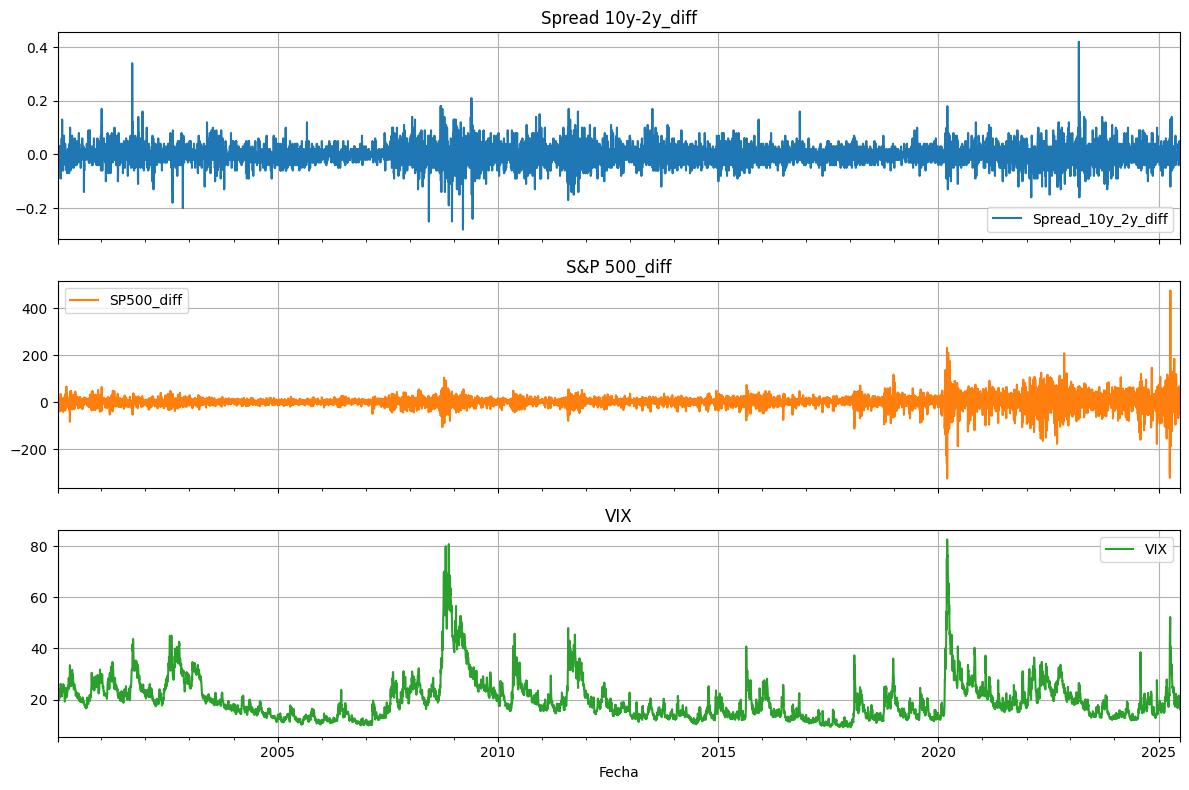

In [ ]:
## Printeamos las Series Diferenciadas

series_diff.plot(
    subplots=True,
    layout=(3, 1),
    figsize=(12, 8),
    sharex=True,
    title=["Spread 10y-2y_diff", "S&P 500_diff", "VIX"],
    grid=True
)

plt.tight_layout()
plt.show()


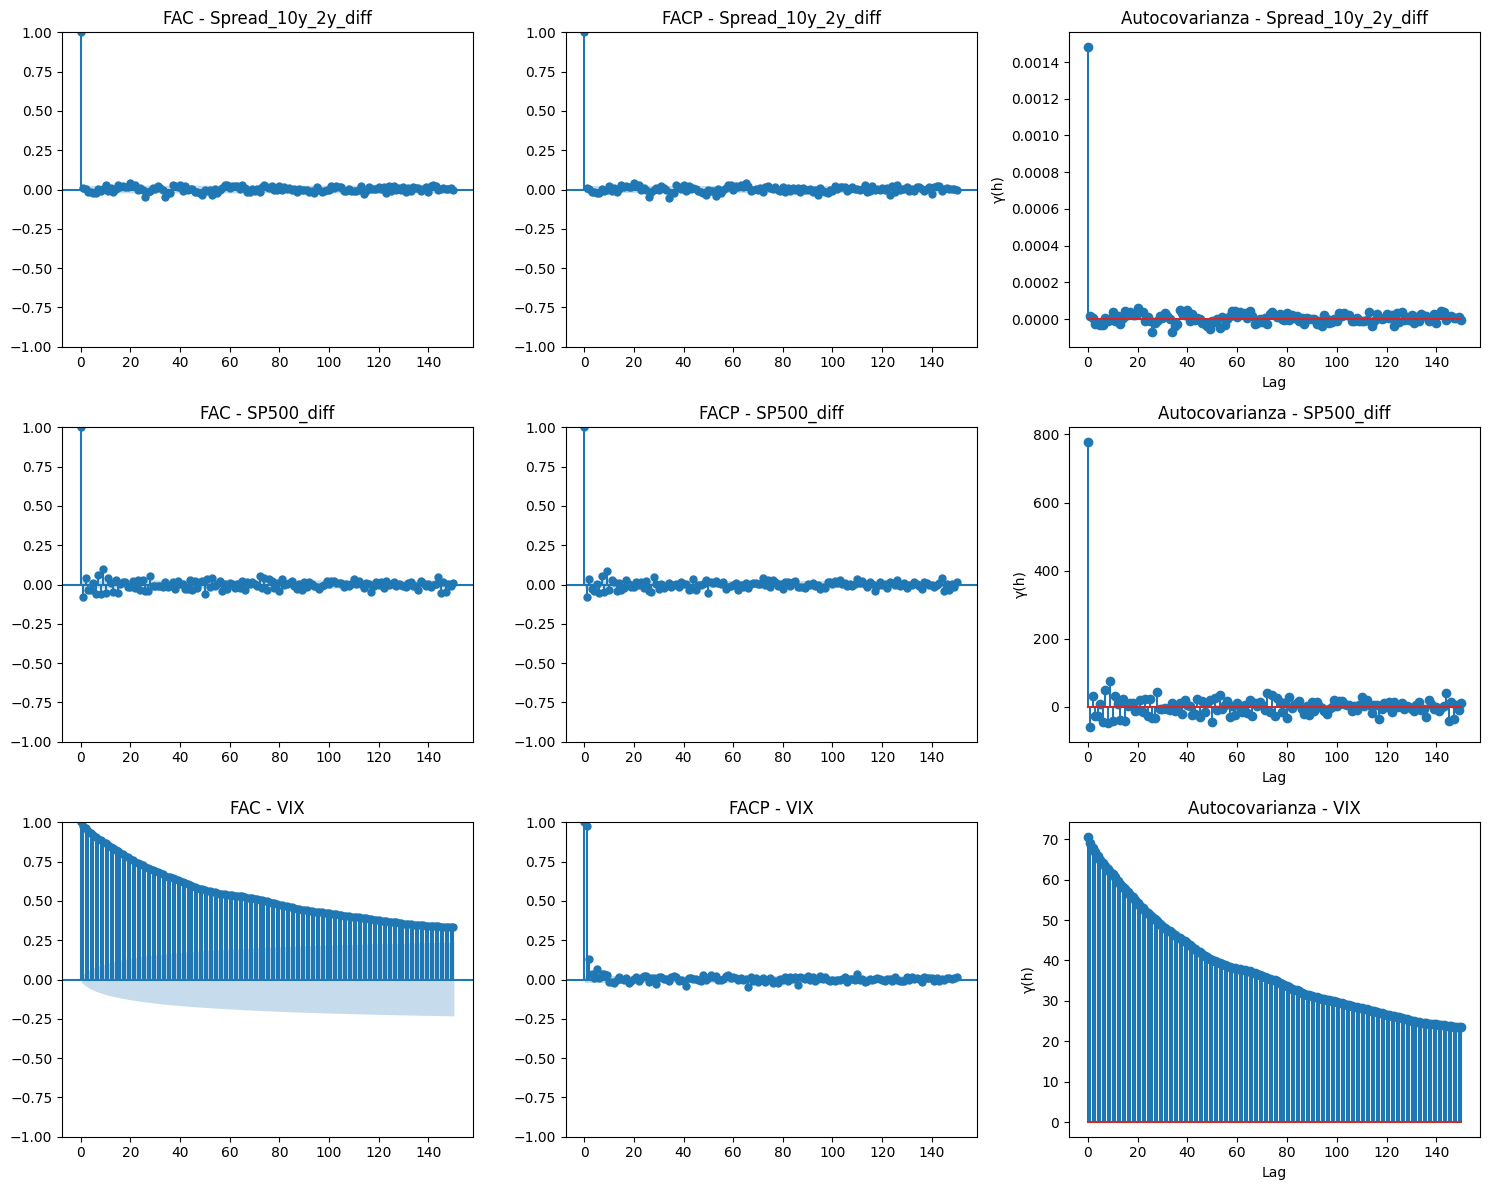

In [ ]:
## Calculamos ACF - PACF y Autocovarianza para las series diferenciadas

# Crear figura con 3 filas (una por serie) y 3 columnas (FAC, FACP, Autocovarianza)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
series_names = ['Spread_10y_2y_diff', 'SP500_diff', 'VIX']
lags=150

for i, col in enumerate(series_names):
    data = series_diff[col].dropna()

    # FAC
    plot_acf(data, ax=axes[i, 0], lags=lags)
    axes[i, 0].set_title(f'FAC - {col}')

    # FACP
    plot_pacf(data, ax=axes[i, 1], lags=lags, method='ywm')
    axes[i, 1].set_title(f'FACP - {col}')

    # AUTOCOVARIANZA
    autocovs = [autocovariance(data.values, lag) for lag in range(lags + 1)]
    axes[i, 2].stem(range(lags + 1), autocovs)
    axes[i, 2].set_title(f'Autocovarianza - {col}')
    axes[i, 2].set_xlabel("Lag")
    axes[i, 2].set_ylabel("γ(h)")

plt.tight_layout()
plt.show()

# Estimación de la serie temporal con distintos órdenes de parámetros de modelos SARIMA

In [ ]:
# -----------------------------------------
# 1. Función de búsqueda SARIMA genérica optimizada
# -----------------------------------------
def sarima_grid_search(
    y,
    p_range=[0,1,2],      # Rangos ARIMA p
    d_range=[0,1],        # Rangos ARIMA d
    q_range=[0,1,2],      # Rangos ARIMA q
    P_range=[0,1,2],      # Rangos estacionales P
    D_range=[0,1],        # Rangos estacionales D
    Q_range=[0,1],        # Rangos estacionales Q
    s_range=[0, 5, 22, 261],        # Rangos periodicidad s
    debug=False
):
    """
    Recorre grid SARIMA(p,d,q)x(P,D,Q,s) sin retener objetos intermedios.
    Usa gc.collect() tras cada iteración para liberar RAM.

    Parámetros:
        y (pd.Series): serie original.
        p_range, d_range, q_range, P_range, D_range, Q_range, s_range: iterables de p, d, q, P, D, Q, S.
        debug (bool): modo verboso si True (sin tqdm).

    Retorna:
        best_model: SARIMAXResults del mejor ajuste.
        results_df: tabla con ['order','seasonal_order','aic','bic','llf'].
    """
    # 1) Generar todas las combinaciones válidas
    configs = [
        (p, d, q, P, D, Q, s)
        for p, d, q in itertools.product(p_range, d_range, q_range)
        for P, D, Q in itertools.product(P_range, D_range, Q_range)
        for s in s_range
        if not (s == 0 and any([P, D, Q]))
    ]

    records = []
    iterator = configs if debug else tqdm(
        configs, desc="Grid Search SARIMA", total=len(configs), unit="cfg"
    )

    # 2) Recorrer sin almacenar modelo completo
    for p, d, q, P, D, Q, s in iterator:
        order = (p, d, q)
        seasonal_order = (P, D, Q, s)
        if debug:
            print(f"Probando SARIMA(order={order}, seasonal={seasonal_order})")
        try:
            model = SARIMAX(
                y,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=True,
                enforce_invertibility=True
            )
            res = model.fit(disp=False)
            # Guardar solo métricas y log-likelihood
            records.append({
                'order': order,
                'seasonal_order': seasonal_order,
                'aic': res.aic,
                'bic': res.bic,
                'llf': res.llf
            })
            if debug:
                print(f"  -> AIC={res.aic:.2f}, BIC={res.bic:.2f}\n")
        except Exception as e:
            if debug:
                print(f"  ❌ Error: {e}\n")
        finally:
            # liberar memoria intermedia si existen
            try:
                del res
            except NameError:
                pass
            try:
                del model
            except NameError:
                pass
            gc.collect()

    # 3) DataFrame de resultados
    results_df = pd.DataFrame(records)
    if results_df.empty:
        raise ValueError("No se ajustaron modelos SARIMA: revise parámetros y datos.")

    # 4) Selección del mejor
    results_df = results_df.sort_values('aic').reset_index(drop=True)
    best = results_df.iloc[0]

    # 5) Refit del mejor modelo solo una vez
    best_model = SARIMAX(
        y,
        order=best['order'],
        seasonal_order=best['seasonal_order'],
        enforce_stationarity=True,
        enforce_invertibility=True
    ).fit(disp=False)
    gc.collect()

    return best_model, results_df



In [ ]:
# -----------------------------------------
# 2. Diagnóstico de residuos
# -----------------------------------------
def diagnostico_residuos(res, nombre="Serie"):
    resid = res.resid.dropna()
    print(f"\n📉 Diagnóstico de residuos - {nombre}")
    # 1) Residuos
    plt.figure(figsize=(10, 3))
    plt.plot(resid)
    plt.title(f"Residuos - {nombre}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # 2) FAC
    sm.graphics.tsa.plot_acf(resid, lags=40)
    plt.title(f"FAC residuos - {nombre}")
    plt.tight_layout()
    plt.show()
    # 3) QQ-plot
    sm.qqplot(resid, line='s')
    plt.title(f"QQ-plot residuos - {nombre}")
    plt.tight_layout()
    plt.show()
    # 4) Jarque-Bera
    jb_stat, jb_p, _, _ = sm.stats.jarque_bera(resid)
    print(f"Jarque-Bera: estadístico={jb_stat:.2f}, p-valor={jb_p:.4f}")
    print("⚠️ No normal" if jb_p < 0.05 else "✅ Normal")
    # 5) Ljung-Box
    lb = acorr_ljungbox(resid, lags=[10, 20, 30], return_df=True)
    print("\nLjung-Box:")
    display(lb)


In [ ]:

# -----------------------------------------
# 3. Configuraciones para cada serie
# -----------------------------------------
# Rangos ARIMA (no estacionales)
p_range = [0,1,2]
d_range = [0,1]
q_range = [0,1,2]
# Rangos estacionales
P_range = [0,1,2]
D_range = [0,1]
Q_range = [0,1]
# Periodicidades
s_range = [0,5]

# Diccionario de grilla para cada serie usando los rangos anteriores:
grid_params = {
    'Spread_10y_2y': {
        'p_range': p_range, 'd_range': d_range, 'q_range': q_range,
        'P_range': P_range, 'D_range': D_range, 'Q_range': Q_range, 's_range': s_range
    },
    'SP500': {
        'p_range': p_range, 'd_range': d_range, 'q_range': q_range,
        'P_range': P_range, 'D_range': D_range, 'Q_range': Q_range, 's_range': s_range
    },
    'VIX': {
        'p_range': p_range, 'd_range': d_range, 'q_range': q_range,
        'P_range': P_range, 'D_range': D_range, 'Q_range': Q_range, 's_range': s_range
    }
}


In [ ]:
## GridSearch para SARIMA -- Comentado dado que entrenamos con los mejores parámetros obtenidos

# # -----------------------------------------
# # 4. Ejecución: grid search + diagnóstico
# # -----------------------------------------
# mejores_modelos = {}
# for name, params in grid_params.items():
#     print(f"\n=== Ajustando SARIMA para {name} ===")
#     y = series[name].dropna()
#     best_model, df_res = sarima_grid_search(
#         y,
#         p_range=params['p_range'],
#         d_range=params['d_range'],
#         q_range=params['q_range'],
#         P_range=params['P_range'],
#         D_range=params['D_range'],
#         Q_range=params['Q_range'],
#         s_range=params['s_range'],
#         debug=False
#     )
#     print(f"Mejor {name}: SARIMA{df_res.loc[0,'order']} x {df_res.loc[0,'seasonal_order']} "
#           f"(AIC={df_res.loc[0,'aic']:.2f}, BIC={df_res.loc[0,'bic']:.2f})")
#     display(df_res[['order','seasonal_order','aic','bic']].head())
#     df_res.to_csv(f"sarima_grid_AIC_BIC_{name}.csv", index=False)
#     diagnostico_residuos(best_model, nombre=name)
#     mejores_modelos[name] = best_model


Los mejores modelos según AIC son:

- Mejor Spread_10y_2y: SARIMA(0, 1, 0) x (2, 0, 1, 5) (AIC=-24446.62, BIC=-24419.41)
- Mejor SP500: SARIMA(2, 1, 2) x (2, 1, 1, 5) (AIC=62980.65, BIC=63035.06)
- Mejor VIX: SARIMA(2, 0, 1) x (0, 1, 1, 5) (AIC=26382.10, BIC=26416.11)


#Métrica de performance teniendo en cuenta el entrenamiento del modelo entre Training Set y Testing Set.

## Cross Validation con distintos parámetros SARIMA y comparación con Baseline

In [ ]:
# # Definimos el modelo naive, modelo baseline forecast
# # Forecast naive baseline
# def naive_forecast(train, horizon):
#     """
#     Pronóstico naive: repite el último valor conocido para todos los pasos.
#     """
#     last = train.iloc[-1]
#     return np.full(horizon, last)

In [ ]:
## Comparación cross validation entre SARIMA (con distintos hiperparámetros) y Baseline, se comenta dado que ya tenemos los mejores parámetros para el modelo

# # --- Evaluación de grilla modularizada ---
# def evaluate_grid_modular(
#     series,
#     p_range=[0,1,2], d_range=[0,1], q_range=[0,1,2],            # Rangos ARIMA
#     P_range=[0,1,2], D_range=[0,1], Q_range=[0,1],              # Rangos estacionales
#     s_range=[0,5],                                          # Periodicidades
#     horizon=10, folds=10, step=10,                           # CV parámetros
#     debug=False                                             # Modo debug
# ):
#     """
#     Genera la grilla SARIMA internamente y evalúa:
#       - Para cada (order, seasonal_order) en la grilla, usa SARIMAModel
#       - También evalúa NaiveModel
#     Devuelve DataFrame con métricas.
#     """
#     # 1. Construir la grilla automáticamente
#     sarima_grid = list(itertools.product(
#         [(p,d,q) for p in p_range for d in d_range for q in q_range],
#         [(P,D,Q,s) for P in P_range for D in D_range for Q in Q_range for s in s_range]
#     ))

#     records = []
#     total = len(sarima_grid) + 1  # +1 para baseline
#     idx = 0
#     # 2. Evaluar cada configuración SARIMA
#     iterator = sarima_grid if debug else tqdm(sarima_grid, desc="Grid Search SARIMA", total=len(sarima_grid))
#     for (order, seasonal_order) in iterator:
#         idx += 1
#         # Omitir invalidas: sin periodo but P/D/Q !=0
#         if seasonal_order[3] == 0 and any(seasonal_order[:3]):
#             if debug:
#                 print(f"Skipping invalid SARIMA{order}x{seasonal_order}")
#             continue
#         if debug:
#             print(f"[{idx}/{total}] Evaluando SARIMA{order}x{seasonal_order}")
#         metrics = cross_validate_model(
#             SARIMAModel,
#             {'order': order, 'seasonal_order': seasonal_order},
#             series,
#             horizon=horizon,
#             folds=folds,
#             step=step,
#             debug=debug
#         )
#         records.append({
#             'model': f'ARIMA{order}x{seasonal_order}',
#             'order': order,
#             'seasonal_order': seasonal_order,
#             **metrics
#         })
#     # 3. Evaluar baseline naive Evaluar baseline naive
#     idx += 1
#     if debug:
#         print(f"[{idx}/{total}] Evaluando Naive")
#     metrics = cross_validate_model(
#         NaiveModel, {}, series,
#         horizon=horizon,
#         folds=folds,
#         step=step,
#         debug=debug
#     )
#     records.append({
#         'model': 'Naive',
#         'order': (None,None,None),
#         'seasonal_order': (None,None,None,None),
#         **metrics
#     })

#     # 4. Devolver resultados
#     return pd.DataFrame(records)



In [ ]:
# # --- Ejecución unificada para todas las series ---
# all_results = []
# for col in series_train.columns:
#     print(f"\n=== Evaluación para {col} ===")
#     df_metrics = evaluate_grid_modular(
#         series_train[col],
#         # p_range=[0,1], #Descomentar para prueba rápida (son muchos menos valores que el default)
#         # d_range=[0,1],
#         # q_range=[0],            # Rangos ARIMA
#         # P_range=[0],
#         # D_range=[0],
#         # Q_range=[0],
#         # s_range=[0,5],
#         horizon=horizon, step=step, folds=folds, debug=False
#     )
#     df_metrics['series'] = col
#     all_results.append(df_metrics)

# # Concatenar todo en un DataFrame
# resultados_search_grid_sarima = pd.concat(all_results, ignore_index=True)

In [ ]:
# # Ordenar y mostrar el top 5 de RMSE para cada serie
# top_5_rmse_por_serie = resultados_search_grid_sarima.sort_values(
#     ['series', 'rmse'],
#     ascending=[True, True]  # series ascendente, RMSE ascendente
# ).groupby('series').head(5).reset_index(drop=True)

# top_5_rmse_por_serie

In [ ]:
#  from google.colab import drive
#  drive.mount('/content/drive')
#  %cd drive/MyDrive/Colab\ Notebooks
# # resultados_search_grid_sarima = pd.read_csv("resultados_search_grid_sarima.csv")

In [ ]:
# # Ordenar y mostrar el gridsearch completo
# resultados_search_grid_sarima.sort_values(
#     ['series', 'rmse'],
#     ascending=[True, True]    # series ascendente, RMSE ascendente
# ).reset_index(drop=True)

In [ ]:
# resultados_search_grid_sarima.to_csv("resultados_search_grid_sarima.csv", index=False)


- Para SP500 el mejor modelo es (2, 0, 2)x(0, 1, 0, 5).
- Para el spread, el mejor modelo es ARIMA(2, 0, 1)x(2, 1, 1, 5).
- Para el VIX, el mejor modelo es (2, 1, 1)x(0, 0, 1, 5).


- Spread 10y-2y: Los tests ADF, KPSS y Phillips-Perron indicaron que la serie no era estacionaria. El modelo que logró la mejor capacidad de pronóstico fue
$$SARIMA(2,0,1)×(2,1,1,5),$$ lo que implica que no se utilizó una diferencia ordinaria (d = 0), pero sí una diferencia estacional (D = 1) con período s=5. Esta diferencia elimina patrones que se repiten regularmente cada 5 observaciones (como puede ocurrir en datos diarios con ciclos semanales) y se define como:$$\nabla_{5}Y_t \;=\; Y_t \;-\; Y_{t-5}.$$ En este caso, además se incluyeron componentes AR y MA tanto en la parte regular como en la estacional. La diferencia estacional resultó clave para estabilizar la serie sin necesidad de diferenciarla por nivel.


- VIX: Aunque el test ADF mostró estacionariedad (p < 0.01), el modelo con mejor desempeño en validación cruzada fue $$SARIMA(2,1,1)×(0,0,1,5).$$ Aquí se aplicó una diferencia ordinaria (d = 1) para eliminar una leve tendencia, mientras que en la parte estacional se incorporó un solo término MA (Q = 1) a lag 5. No fue necesario aplicar diferencia estacional (D = 0). Este ajuste combina un suavizado de las oscilaciones de corto plazo con una captura del patrón estacional, mejorando el pronóstico sin sobreajustar.


- S&P 500: Los tres tests coincidieron en que la serie original no era estacionaria. El mejor modelo encontrado fue $$SARIMA(2,0,2)×(0,1,0,5),$$
donde no se aplicó diferencia ordinaria (d = 0), pero sí una diferencia estacional con D=1 y s=5. Esta operación $$\nabla_{5}Y_t \;=\; Y_t \;-\; Y_{t-5}$$ eliminó eficazmente la raíz unitaria asociada a un ciclo semanal. Los términos AR y MA de orden 2 permiten modelar dependencias de corto plazo. Este modelo fue superior en predicción, mostrando que a veces basta con estabilizar la componente estacional sin necesidad de diferenciar también por nivel.

In [ ]:
# Con la diferenciación estacional SP500 es estacionaria!
y = series_train['SP500']          # serie original
y_sdiff = y.diff(5).dropna()       # diferencia estacional (lag 5)

# --- Test ADF ---
adf_p = adfuller(y_sdiff)[1]

# --- Test KPSS (H0 = estacionaria) ---
kpss_p = kpss(y_sdiff, nlags='auto')[1]

# --- Test Phillips–Perron ---
pp_p   = PhillipsPerron(y_sdiff).pvalue

print(f"ADF   sobre diff estacional: p-valor = {adf_p:.4f}")
print(f"KPSS  sobre diff estacional: p-valor = {kpss_p:.4f}")
print(f"PP    sobre diff estacional: p-valor = {pp_p:.4f}")



NameError: name 'series_train' is not defined

In [ ]:
# Con la diferenciación estacional Spread_10y_2y es estacionaria (por sistema de votación)
y = series_train['Spread_10y_2y']          # serie original
y_sdiff = y.diff(5).dropna()       # diferencia estacional (lag 5)

# --- Test ADF ---
adf_p = adfuller(y_sdiff)[1]

# --- Test KPSS (H0 = estacionaria) ---
kpss_p = kpss(y_sdiff, nlags='auto')[1]

# --- Test Phillips–Perron ---
pp_p   = PhillipsPerron(y_sdiff).pvalue

print(f"ADF   sobre diff estacional: p-valor = {adf_p:.4f}")
print(f"KPSS  sobre diff estacional: p-valor = {kpss_p:.4f}")
print(f"PP    sobre diff estacional: p-valor = {pp_p:.4f}")


ADF   sobre diff estacional: p-valor = 0.0000
KPSS  sobre diff estacional: p-valor = 0.1000
PP    sobre diff estacional: p-valor = 0.0000


In [ ]:
#Descomentar para pruebas individuales (debugging)
# cross_validate_model(
#     SARIMAModel,                            # Clase de modelo
#     {'order': (1,1,0),                     # Parámetros ARIMA
#      'seasonal_order': (0,0,0,5)},         # Parámetros estacionales
#     series_train['SP500'].dropna(), # Serie univariada
#     horizon=10,                             # Horizonte de pronóstico
#     folds=10,                               # Número de folds
#     step=10,                                # Paso entre folds
#     debug=True                              # Para ver cada fold
# )

In [ ]:
#Descomentar para pruebas individuales (debugging)
# evaluate_grid(series_train['Spread_10y_2y'],
#     p_range=[1, 2], d_range=[0], q_range=[0],            # Rangos para los parámetros ARIMA
#     P_range=[1], D_range=[1], Q_range=[0],            # Rangos para los parámetros estacionales
#     s_range=[5],                                          # Rangos de periodicidad (0 = no estacional)
#     horizon=10, folds=10, step=10,                    # Configuración de CV
#     debug=True)

In [ ]:
# #Más posible código para debug:

# # # ----------------------------------------
# # # Supongamos que ya tienes un DataFrame `series`
# # # con la columna que quieres probar, por ejemplo:
# col = 'Spread_10y_2y'
# per = 5             # el período estacional que quieres comprobar
# horizon = 10        # horizonte de forecast

# # 1) Split train / test
# y = series[col].dropna()
# train, test = y.iloc[:-horizon], y.iloc[-horizon:]

# # 2) Ajustar SARIMA(2,0,0)x(0,0,0,per)
# order = (2, 0, 0)
# seasonal_order = (2, 0, 0, per)
# model = SARIMAX(train,
#                 order=order,
#                 seasonal_order=seasonal_order,
#                 enforce_stationarity=True,
#                 enforce_invertibility=True)
# res = model.fit(disp=False)

# # 3) Forecast a `horizon` pasos
# pred = res.get_forecast(steps=horizon).predicted_mean

# # 4) Mostrar reales vs predicciones
# print("Valores reales:     ", test.values)
# print("Predicciones:        ", pred.values)

# # 5) Cálculo paso a paso de MAE y MAPE
# errors        = test.values - pred.values
# abs_errors    = np.abs(errors)
# mae           = abs_errors.mean()

# # Evitar división por cero en MAPE
# mask = test.values != 0
# mape_indiv    = np.abs(errors[mask] / test.values[mask]) * 100
# mape_overall  = mape_indiv.mean() if len(mape_indiv) else np.nan

# print("\nErrores absolutos:   ", abs_errors)
# print("MAE:                ", mae)
# print("\nMAPE individuales:  ", mape_indiv)
# print("MAPE promedio:      ", mape_overall)


#### Gráficos de los folds de los mejores modelos

In [ ]:
# ─── Objetos SARIMAModel con los mejores parámetros (aún SIN entrenar) ────
sp500_model  = SARIMAModel(order=sarima_models_params['SP500']['order'], seasonal_order=sarima_models_params['SP500']['seasonal_order'])
spread_model = SARIMAModel(order=sarima_models_params['Spread_10y_2y']['order'], seasonal_order=sarima_models_params['Spread_10y_2y']['seasonal_order'])
vix_model    = SARIMAModel(order=sarima_models_params['VIX']['order'], seasonal_order=sarima_models_params['VIX']['seasonal_order'])

In [ ]:
models_dict = {
    "SP500":  sp500_model,
    "Spread_10y_2y": spread_model,
    "VIX":    vix_model,
}

In [ ]:
def plot_folds(series_name, series, model_obj, horizon, folds, step):
    """
    Muestra la serie completa (en negro, etiqueta 'Dato real') y los pronósticos
    de cada fold (mismo color, sin etiqueta) dentro de la ventana final
    de longitud 2 * step * folds.
    """
    # --- preparar serie y cortes ----------------------------------------
    y_full = series.dropna()
    n = len(y_full)

    start_point = n - horizon - step * (folds - 1)

    window = 2 * step * folds                                     # ventana a graficar
    plot_start = max(0, n - window)
    y_plot = y_full.iloc[plot_start:]                             # recorte a mostrar

    # --- figura base ----------------------------------------------------
    plt.figure(figsize=(12, 4))
    plt.plot(
        y_plot.index,       # Ahora se usa el índice de fechas de y_plot
        y_plot.values,
        color="black",        # línea negra
        label="Dato real"     # única entrada en la leyenda
    )

    # --- recorrer folds -------------------------------------------------
    for f, end_train in enumerate(range(start_point, n - horizon + 1, step), 1):
        if f > folds:         # detener tras el nº de folds deseado
            break

        train = y_full.iloc[:end_train]

        # instanciar un modelo equivalente (clonar la configuración)
        model = SARIMAModel(
            order=model_obj.order,
            seasonal_order=model_obj.seasonal_order,
            enforce_stationarity=model_obj.enforce_stationarity,
            enforce_invertibility=model_obj.enforce_invertibility
        ).fit(train)

        forecast = model.forecast(horizon)
        test_idx = range(end_train, end_train + horizon)

        # dibujar solo la parte dentro de la ventana
        in_window = [i for i in test_idx if i >= plot_start]
        if in_window:
            offset = in_window[0] - end_train

            # Se usa y_full.index[in_window] para que el eje X
            # del pronóstico coincida con las fechas correctas.
            plt.plot(
                y_full.index[in_window],
                forecast[offset: offset + len(in_window)],
                lw=1.8,
                color="C1",       # mismo color para todos los pronósticos
                label=None        # sin etiqueta: no aparece en la leyenda
            )

    # --- formato final --------------------------------------------------
    plt.title(f"{series_name}: últimos {window} puntos y pronósticos (h={horizon})")
    plt.xlabel("Fecha")
    plt.ylabel("Valor")
    plt.legend(loc="best", fontsize="small")   # sólo “Dato real”
    plt.grid(True)
    plt.tight_layout()
    plt.show()




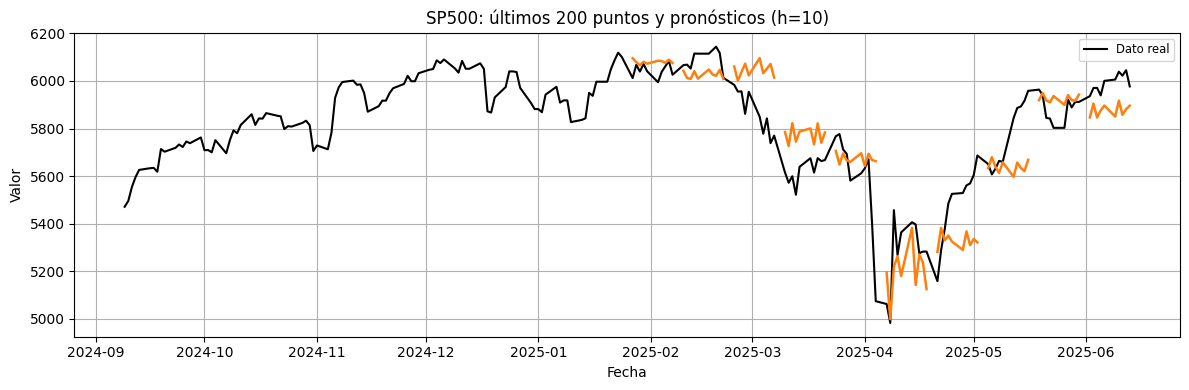

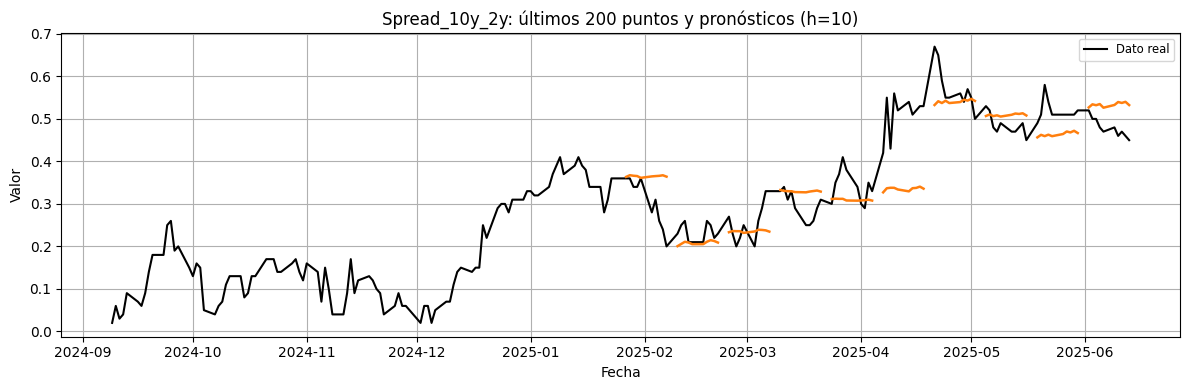

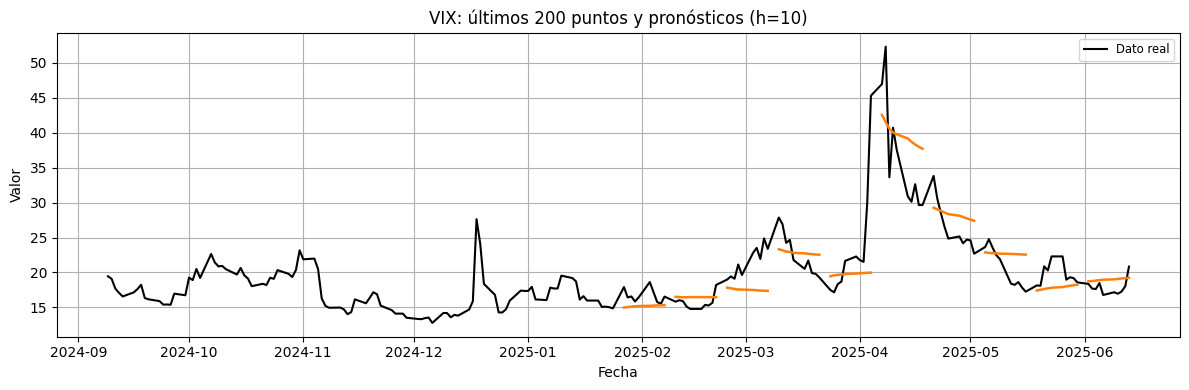

In [ ]:
# --- Ejecutar para cada serie ----------------------------------------
for name, model in models_dict.items():
    plot_folds(
        series_name=name,
        series=series_train[name],   # ajustá aquí si tu variable DataFrame cambia
        model_obj=model,
        horizon=horizon,
        folds=folds,
        step=step
    )

## Gráfico de las predicciones y comparación con el modelo de Holt-Winters

### Primero buscamos el mejor modelo de Holt-Winters con cross-validation

In [ ]:
# =============================================================================
# 1. Modelo Holt-Winters con la interfaz fit / forecast (compatible con CV)
# =============================================================================
class HoltWintersModel(BaseModel):
    """
    Envoltura ligera para statsmodels.ExponentialSmoothing.

    Mantiene la interfaz:
        .fit(series)      -> devuelve self
        .forecast(h)      -> np.array con h pasos
        .aic / .bic       -> criterios de información (si el backend los expone)
    """
    def __init__(self,
                 trend=None,            # 'add', 'mul' o None
                 damped_trend=False,    # booleano
                 seasonal=None,         # 'add', 'mul' o None
                 seasonal_periods=None, # int o None
                 use_boxcox=False,      # False, True o 'log'
                 initialization_method="estimated"):
        # Se guardan los hiperparámetros
        self.trend = trend
        self.damped_trend = damped_trend
        self.seasonal = seasonal
        self.seasonal_periods = seasonal_periods
        self.use_boxcox = use_boxcox
        self.initialization_method = initialization_method
        self.result = None             # se llenará en .fit()

    # ------------- ajuste --------------------------------------------------
    def fit(self, series):
        model = ExponentialSmoothing(
            series,
            trend=self.trend,
            damped_trend=self.damped_trend,
            seasonal=self.seasonal,
            seasonal_periods=self.seasonal_periods,
            initialization_method=self.initialization_method,
            use_boxcox=self.use_boxcox
        )
        # optimized=True -> deja que statsmodels encuentre los alfas/betas/gammas
        self.result = model.fit(optimized=True)
        return self

    # ------------- pronóstico ---------------------------------------------
    def forecast(self, horizon):
        return self.result.forecast(horizon).values

    # ------------- criterios de información --------------------------------
    @property
    def aic(self):
        # ExponentialSmoothing expone .aic/.bic desde statsmodels >= 0.14
        return getattr(self.result, "aic", np.nan)

    @property
    def bic(self):
        return getattr(self.result, "bic", np.nan)

# -----------------------------------------------------------------------------
# Significado de los hiperparámetros
# -----------------------------------------------------------------------------
# trend              : 'add'  (tendencia lineal aditiva)
#                      'mul'  (tendencia multiplicativa, crece en %)
#                      None   (sin tendencia)
#
# damped_trend       : aplica un factor phi (<1) que “aplaca” la tendencia.
#
# seasonal           : 'add'  (estacionalidad aditiva: mismo tamaño a lo largo
#                               del tiempo)
#                      'mul'  (estacionalidad multiplicativa: varía en %)
#                      None   (sin componente estacional)
#
# seasonal_periods   : número de observaciones por ciclo (p. ej. 5, 12, 52…).
#
# use_boxcox         : False → sin transformación
#                      True  → aplica Box-Cox y estima lambda
#                      'log' → equivalente a lambda = 0  (logaritmo)
# -----------------------------------------------------------------------------



In [ ]:
# --------------------------------------------------------------------------
# 2.  Búsqueda en grilla Holt-Winters con la misma CV que usás para SARIMA
# --------------------------------------------------------------------------
def evaluate_hw_grid(
    series,
    # rangos de hiperparámetros a explorar
    trend_opts=("add", "mul", None),
    damped_opts=(False,),
    seasonal_opts=("add", "mul", None),
    seasonal_periods_opts=(0, 5),
    use_boxcox_opts=(False,),
    # configuración de CV
    horizon=10, folds=10, step=10,
    debug=False
):
    """
    Recorre todas las combinaciones Holt-Winters, evalúa CV
    y añade el baseline Naive. Devuelve un DataFrame con las métricas medias.
    """
    records = []

    # 1. Construir la grilla completa
    hw_grid = list(itertools.product(
        trend_opts,
        damped_opts,
        seasonal_opts,
        seasonal_periods_opts,
        use_boxcox_opts
    ))

    # 2. Prefiltrar sólo las combinaciones válidas
    valid_grid = []
    for (trend, damped, seasonal, sp, boxcox) in hw_grid:
        # si no hay estacionalidad, fuerza sp = None
        if seasonal is None:
            sp_eff = None
        else:
            sp_eff = sp
            # si hay estacionalidad pero sp no es válido, skip
            if not sp_eff:
                continue

        # statsmodels no admite trend='mul' + seasonal='add'
        if trend == "mul" and seasonal == "add":
            continue

        valid_grid.append((trend, damped, seasonal, sp_eff, boxcox))

    # 3. Iterar sólo sobre valid_grid, con el conteo correcto
    iterator = valid_grid if debug else tqdm(
        valid_grid,
        desc="Grid Search HW",
        total=len(valid_grid)
    )

    # 4. Evaluar cada combinación filtrada
    for (trend, damped, seasonal, sp, boxcox) in iterator:
        hw_kwargs = dict(
            trend=trend,
            damped_trend=damped,
            seasonal=seasonal,
            seasonal_periods=sp,
            use_boxcox=boxcox
        )
        if debug:
            print(f"Evaluando HW: {hw_kwargs}")

        metrics = cross_validate_model(
            HoltWintersModel,
            hw_kwargs,
            series,
            horizon=horizon,
            folds=folds,
            step=step,
            debug=debug
        )
        records.append({
            "model": f"HW(trend={trend}, damped={damped}, "
                     f"seasonal={seasonal}, sp={sp}, boxcox={boxcox})",
            **metrics
        })

    # 5. Baseline Naive
    baseline_metrics = cross_validate_model(
        NaiveModel, {}, series,
        horizon=horizon, folds=folds, step=step, debug=debug
    )
    records.append({"model": "Naive", **baseline_metrics})

    return pd.DataFrame(records)



In [ ]:
# =============================================================================
# 3. Ejemplo de uso para tus tres series
# =============================================================================
for col in ["Spread_10y_2y", "SP500", "VIX"]:
    print(f"\n=== Holt-Winters grid para {col} ===")
    df_hw = evaluate_hw_grid(
    series_train[col].dropna(),
    # rangos que SÍ querés explorar
    trend_opts=("add", "mul", None),
    seasonal_opts=("add", "mul", None),
    seasonal_periods_opts=(0, 5),
    use_boxcox_opts=(False,),       # <--  sin Box-Cox
    horizon=horizon,
    folds=folds,
    step=step,
    debug=False # True para ver cada fold y cada combinación
    )
    # ordenar por rmse ascendente para ver el “mejor”
    display(df_hw.sort_values("rmse").head())


=== Holt-Winters grid para Spread_10y_2y ===


Grid Search HW: 100%|██████████| 11/11 [00:20<00:00,  1.90s/it]


,model,rmse,mae,mape,aic,bic
0,"HW(trend=add, damped=False, seasonal=add, sp=5, boxcox=False)",0.066161,0.057172,14.575610,-42875.655911,-42814.523050
9,"HW(trend=None, damped=False, seasonal=None, sp=None, boxcox=False)",0.066197,0.057100,14.556347,-42884.603016,-42871.017936
10,"HW(trend=None, damped=False, seasonal=None, sp=None, boxcox=False)",0.066197,0.057100,14.556347,-42884.603016,-42871.017936
11,Naive,0.066197,0.057100,14.556347,NaN,NaN
7,"HW(trend=None, damped=False, seasonal=add, sp=5, boxcox=False)",0.066210,0.057212,14.589587,-42879.921952,-42832.374171



=== Holt-Winters grid para SP500 ===


Grid Search HW: 100%|██████████| 11/11 [02:24<00:00, 13.12s/it]


,model,rmse,mae,mape,aic,bic
0,"HW(trend=add, damped=False, seasonal=add, sp=5, boxcox=False)",149.352716,127.016242,2.249098,43268.815382,43329.948243
8,"HW(trend=None, damped=False, seasonal=mul, sp=5, boxcox=False)",149.572615,126.715135,2.243589,43266.959295,43314.507076
7,"HW(trend=None, damped=False, seasonal=add, sp=5, boxcox=False)",149.664231,126.815623,2.245358,43269.816890,43317.364671
9,"HW(trend=None, damped=False, seasonal=None, sp=None, boxcox=False)",149.701628,126.846016,2.245927,43258.725768,43272.310849
10,"HW(trend=None, damped=False, seasonal=None, sp=None, boxcox=False)",149.701628,126.846016,2.245927,43258.725768,43272.310849



=== Holt-Winters grid para VIX ===


Grid Search HW: 100%|██████████| 11/11 [02:19<00:00, 12.70s/it]


,model,rmse,mae,mape,aic,bic
6,"HW(trend=mul, damped=False, seasonal=None, sp=None, boxcox=False)",4.097191,3.369304,13.826529,7404.491336,7431.661497
5,"HW(trend=mul, damped=False, seasonal=None, sp=None, boxcox=False)",4.097191,3.369304,13.826529,7404.491336,7431.661497
4,"HW(trend=mul, damped=False, seasonal=mul, sp=5, boxcox=False)",4.122665,3.386443,13.934290,7346.359066,7407.491927
9,"HW(trend=None, damped=False, seasonal=None, sp=None, boxcox=False)",4.173338,3.441214,14.148950,7407.138259,7420.723339
10,"HW(trend=None, damped=False, seasonal=None, sp=None, boxcox=False)",4.173338,3.441214,14.148950,7407.138259,7420.723339


In [ ]:
all_hw = []
for col in ["Spread_10y_2y", "SP500", "VIX"]:
    ...
    df_hw["serie"] = col          # etiqueta
    all_hw.append(df_hw)

pd.concat(all_hw).to_csv("resultados_hw_grid_todas_series.csv", index=False)

### Predicción en el test y comparación con Holt-Winters

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 1.  Definir los modelos finales (sin entrenar)
# ──────────────────────────────────────────────────────────────────────────────
sarima_models = {
    "SP500": SARIMAModel(order=sarima_models_params['SP500']['order'], seasonal_order=sarima_models_params['SP500']['seasonal_order']),
    "Spread_10y_2y": SARIMAModel(order=sarima_models_params['Spread_10y_2y']['order'], seasonal_order=sarima_models_params['Spread_10y_2y']['seasonal_order']),
    "VIX": SARIMAModel(order=sarima_models_params['VIX']['order'], seasonal_order=sarima_models_params['VIX']['seasonal_order']),
}

holt_models = {
    # HW(trend, damped_trend, seasonal, seasonal_periods, use_boxcox)
    "Spread_10y_2y": HoltWintersModel(trend="add", damped_trend=False,
                            seasonal="add", seasonal_periods=5, use_boxcox=False),
    "SP500":  HoltWintersModel(trend="add", damped_trend=False,
                               seasonal="add", seasonal_periods=5, use_boxcox=False),
    "VIX":    HoltWintersModel(trend="mul", damped_trend=False,
                               seasonal=None, seasonal_periods=None, use_boxcox=False),
}


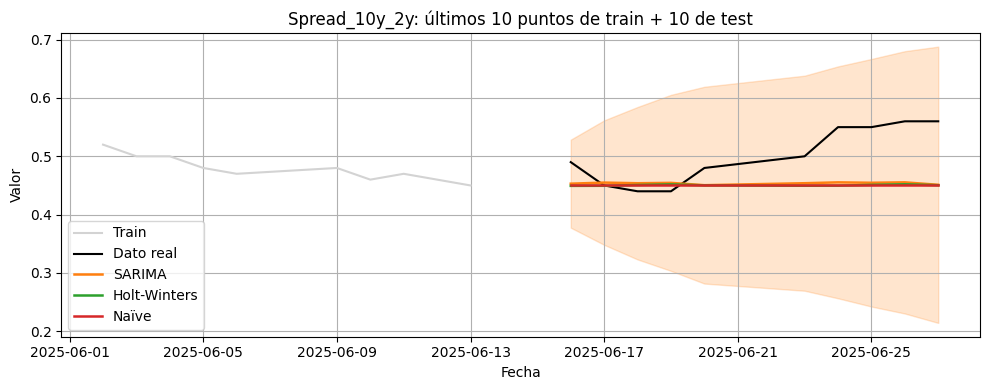


Predicciones vs. dato real – Spread_10y_2y
            Dato real    SARIMA  Holt-Winters  Naïve
Fecha                                               
2025-06-16       0.49  0.453060      0.449307   0.45
2025-06-17       0.45  0.454912      0.449443   0.45
2025-06-18       0.44  0.453827      0.450790   0.45
2025-06-19       0.44  0.454467      0.451807   0.45
2025-06-20       0.48  0.450488      0.450189   0.45

Métricas de pronóstico para Spread_10y_2y
        modelo      rmse       mae       mape
0       SARIMA  0.067567  0.054938  10.312330
1  HoltWinters  0.069938  0.056118  10.499079
2        Naive  0.070285  0.056000  10.460807


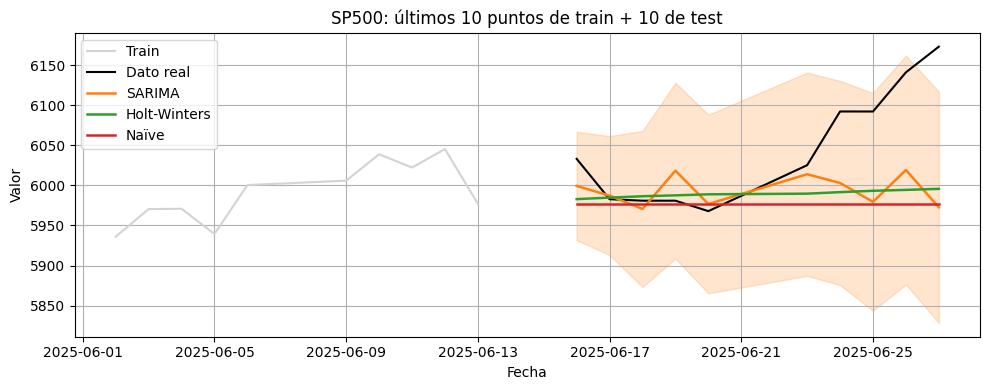


Predicciones vs. dato real – SP500
              Dato real       SARIMA  Holt-Winters        Naïve
Fecha                                                          
2025-06-16  6033.109863  5999.276045   5982.845288  5976.970215
2025-06-17  5982.720215  5987.195964   5984.714197  5976.970215
2025-06-18  5980.870117  5970.542344   5986.429497  5976.970215
2025-06-19  5980.870117  6018.359434   5987.531538  5976.970215
2025-06-20  5967.839844  5976.708339   5988.835123  5976.970215

Métricas de pronóstico para SP500
        modelo       rmse        mae      mape
0       SARIMA  88.644891  63.055138  1.031765
1  HoltWinters  87.873538  64.466322  1.055058
2        Naive  98.757870  71.756885  1.173999


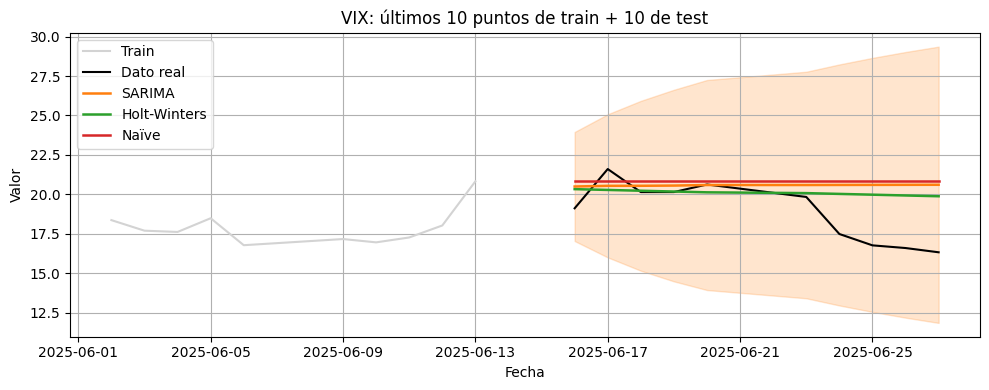


Predicciones vs. dato real – VIX
            Dato real     SARIMA  Holt-Winters  Naïve
Fecha                                                
2025-06-16  19.110001  20.491622     20.324966  20.82
2025-06-17  21.600000  20.534873     20.274345  20.82
2025-06-18  20.139999  20.538055     20.223851  20.82
2025-06-19  20.139999  20.551244     20.173481  20.82
2025-06-20  20.620001  20.585955     20.123238  20.82

Métricas de pronóstico para VIX
        modelo      rmse       mae       mape
0       SARIMA  2.504522  1.928214  11.123294
1  HoltWinters  2.099583  1.604162   9.230351
2        Naive  2.669447  2.117000  12.167711


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 2.  Entrenar, predecir, graficar y tabular por serie (con Naïve)
# ──────────────────────────────────────────────────────────────────────────────
tables = {}

for col in ["Spread_10y_2y", "SP500", "VIX"]:
    # 1. Split final train / test
    y_train = series_train[col].dropna()
    y_test  = series_test[col].dropna()
    h       = len(y_test)  # horizonte (10)

    # 2. Ajustar SARIMA ganador
    sarima      = sarima_models[col].fit(y_train)
    sarima_pred = sarima.forecast(h)

    # 3. Ajustar Holt-Winters ganador
    hw      = holt_models[col].fit(y_train)
    hw_pred = hw.forecast(h)

    # 4. Pronosticador naïve de persistencia
    last_value = y_train.iloc[-1]
    naive_pred = np.repeat(last_value, h)

    # 5. Métricas de error (incluye Naïve)
    metrics = []
    for name, pred in [("SARIMA", sarima_pred),
                       ("HoltWinters", hw_pred),
                       ("Naive", naive_pred)]:
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae  = mean_absolute_error(y_test, pred)
        mp   = mape(y_test, pred)
        metrics.append({"modelo": name, "rmse": rmse, "mae": mae, "mape": mp})

    df_met = pd.DataFrame(metrics)
    tables[col] = df_met

    # 6. Gráfico (añade curva Naïve)
    train_tail    = y_train.tail(h)
    idx_train_tail = train_tail.index
    idx_test       = y_test.index

    # IC 95 % para SARIMA
    sar_res  = sarima.result.get_forecast(h)
    sar_low, sar_high = sar_res.conf_int(alpha=0.05).T.values

    plt.figure(figsize=(10, 4))
    plt.plot(idx_train_tail, train_tail, color="lightgray", label="Train")
    plt.plot(idx_test, y_test,       color="black",  label="Dato real")
    plt.plot(idx_test, sarima_pred,  color="C1",      lw=1.8, label="SARIMA")
    plt.fill_between(idx_test, sar_low, sar_high, color="C1", alpha=0.2)
    plt.plot(idx_test, hw_pred,      color="C2",      lw=1.8, label="Holt-Winters")
    plt.plot(idx_test, naive_pred,   color="C3",      lw=1.8, label="Naïve")
    plt.title(f"{col}: últimos {h} puntos de train + {h} de test")
    plt.xlabel("Fecha")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 7. Tabla de valores reales y predichos (incluye Naïve)
    df_pred = pd.DataFrame({
        "Dato real":    y_test.values,
        "SARIMA":       sarima_pred,
        "Holt-Winters": hw_pred,
        "Naïve":        naive_pred,
    }, index=y_test.index)

    print(f"\nPredicciones vs. dato real – {col}")
    print(df_pred.head())  # o display(df_pred)

    # Guardar CSV
    df_pred.to_csv(f"predicciones_en_test_modelos_clásicos_{col}.csv", index=True)

    # 8. Mostrar y guardar la tabla de métricas
    print(f"\nMétricas de pronóstico para {col}")
    print(df_met)  # o display(df_met)
    df_met.to_csv(f"metrics_en_test_modelos_clásicos_{col}.csv", index=False)


# Análisis de Diagnóstico de las series temporales (luego de training y testing)

In [ ]:
series_a_analizar = {
    "SP500": {
        "order": sarima_models_params['SP500']['order'],
        "seasonal_order": sarima_models_params['SP500']['seasonal_order']
    },
    "Spread_10y_2y": {
        "order": sarima_models_params['Spread_10y_2y']['order'],
        "seasonal_order": sarima_models_params['Spread_10y_2y']['seasonal_order']
    },
    "VIX": {
        "order": sarima_models_params['VIX']['order'],
        "seasonal_order": sarima_models_params['VIX']['seasonal_order']
    }
}



🔍 Evaluando y diagnosticando para SP500


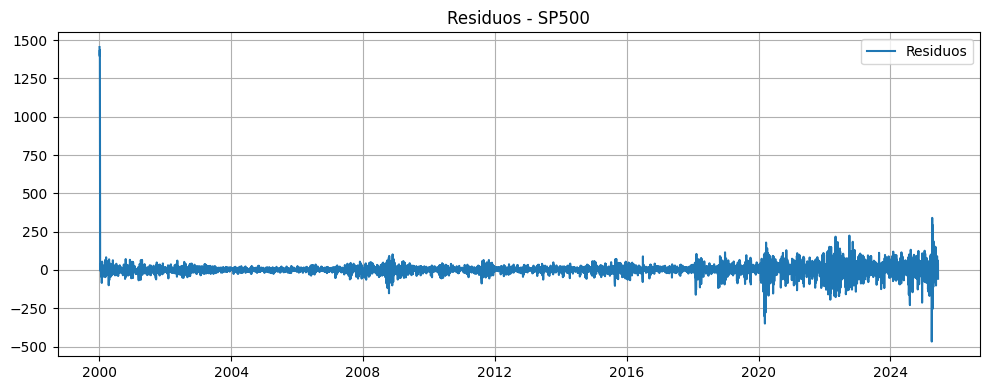

<Figure size 1000x400 with 0 Axes>

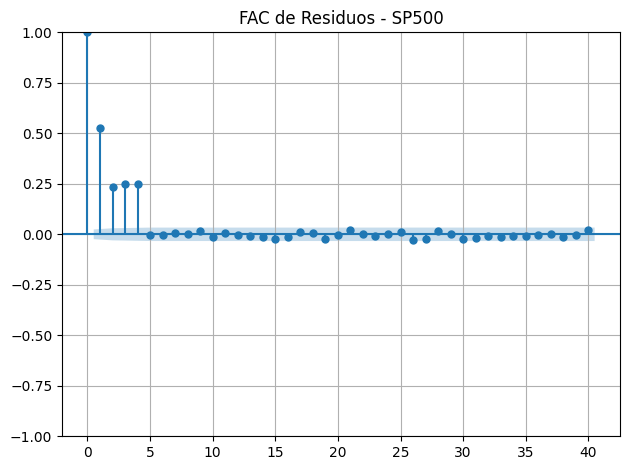

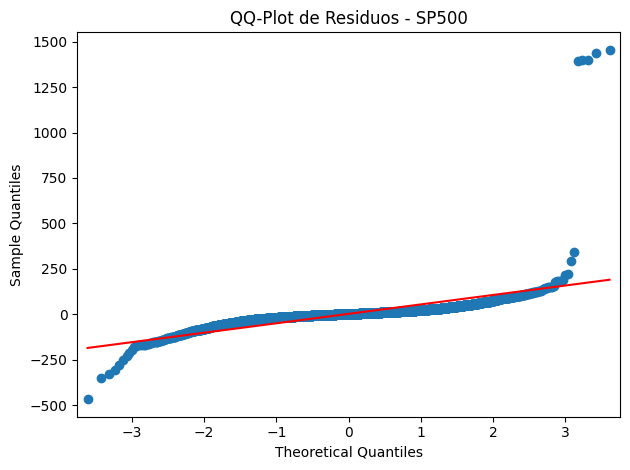

Jarque-Bera: estadístico=47957540.8645, p-valor=0.0000
⚠️ No normal

Test de Ljung-Box para SP500:
        lb_stat  lb_pvalue
10  3047.035259        0.0
20  3058.970540        0.0
30  3077.503218        0.0
RMSE: 88.6418, MAE: 63.0560, MAPE: 1.03%
--------------------------------------------------------------------------------

🔍 Evaluando y diagnosticando para Spread_10y_2y


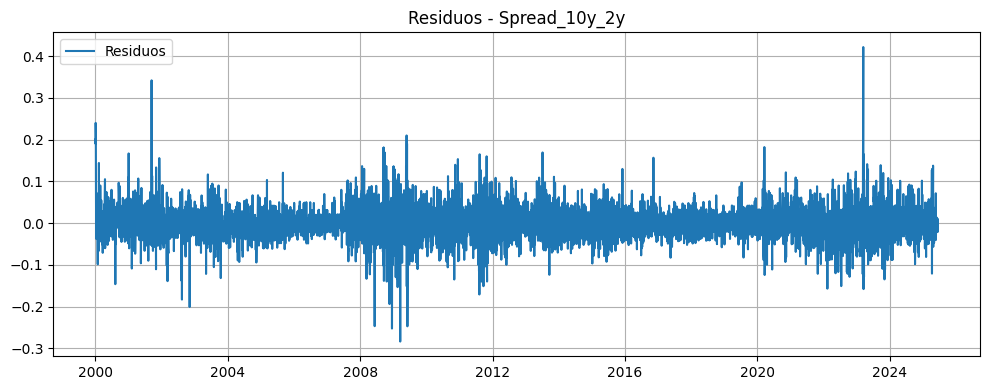

<Figure size 1000x400 with 0 Axes>

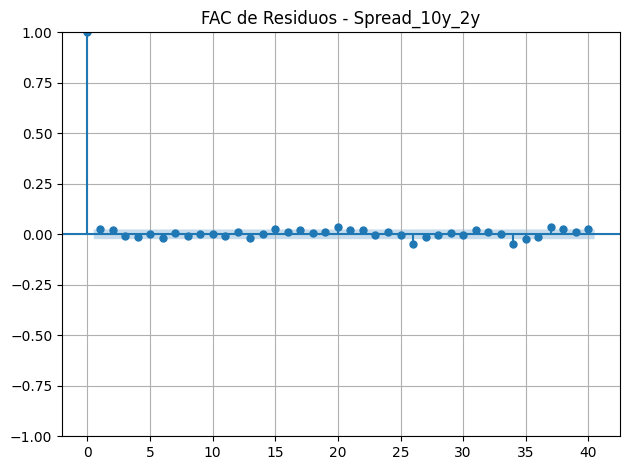

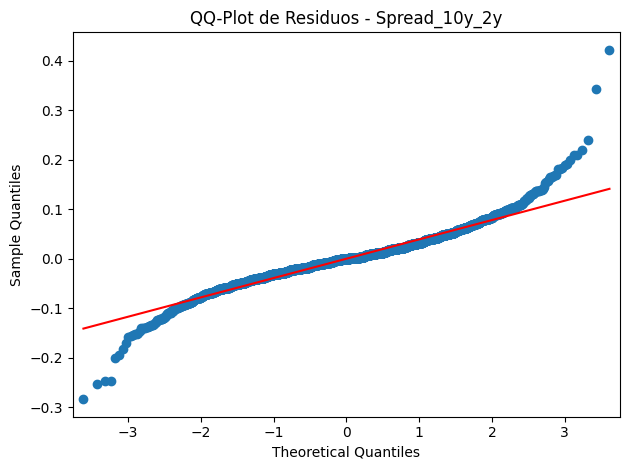

Jarque-Bera: estadístico=11313.3729, p-valor=0.0000
⚠️ No normal

Test de Ljung-Box para Spread_10y_2y:
      lb_stat  lb_pvalue
10  12.222605   0.270435
20  32.257343   0.040632
30  56.515532   0.002381
RMSE: 0.0699, MAE: 0.0562, MAPE: 10.53%
--------------------------------------------------------------------------------

🔍 Evaluando y diagnosticando para VIX


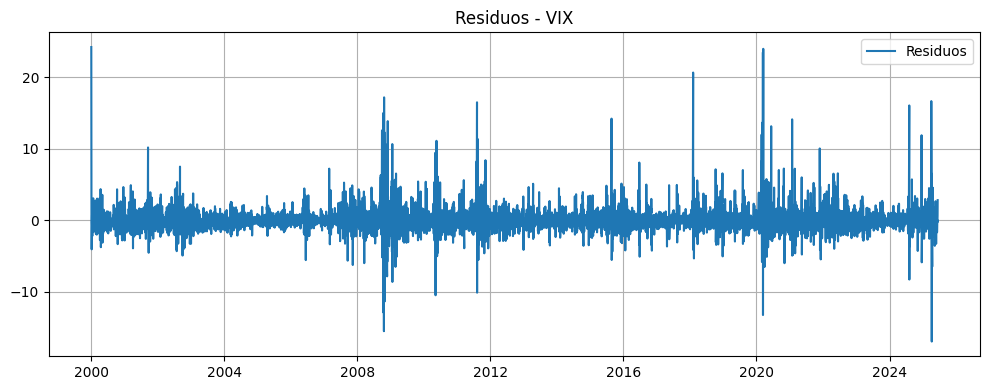

<Figure size 1000x400 with 0 Axes>

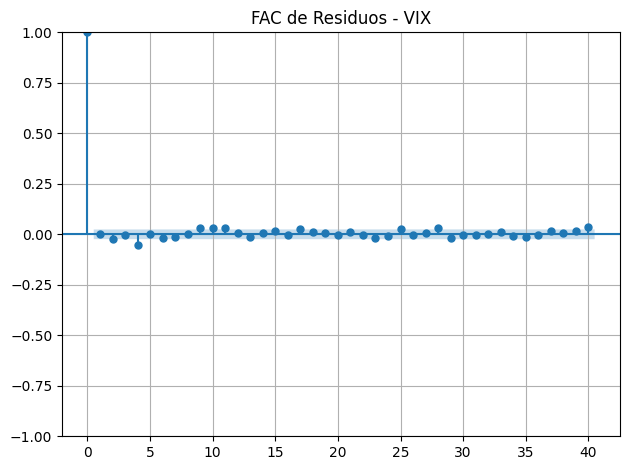

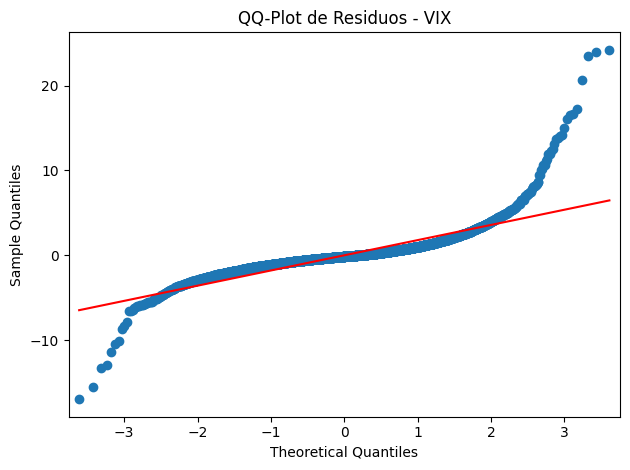

Jarque-Bera: estadístico=286015.9680, p-valor=0.0000
⚠️ No normal

Test de Ljung-Box para VIX:
      lb_stat  lb_pvalue
10  39.350146   0.000022
20  54.211205   0.000054
30  71.696801   0.000029
RMSE: 2.5045, MAE: 1.9282, MAPE: 11.12%
--------------------------------------------------------------------------------


In [ ]:
# Función optimizada para evaluar performance y diagnóstico
def evaluar_diagnostico(serie_train, serie_test, order, seasonal_order, nombre="Serie"):
    print(f"\n🔍 Evaluando y diagnosticando para {nombre}")
    try:
        # Ajustar el modelo en el Training Set
        modelo = SARIMAX(serie_train.dropna(), order=order,
                         seasonal_order=seasonal_order,
                         enforce_stationarity=True, enforce_invertibility=True)
        resultado = modelo.fit(disp=False, maxiter=100)

        # Residuos del Training Set
        residuos = resultado.resid.dropna()

        # Gráfico de Residuos
        plt.figure(figsize=(10, 4))
        plt.plot(residuos, label='Residuos')
        plt.title(f"Residuos - {nombre}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show();

        # Gráfico de FAC
        plt.figure(figsize=(10, 4))
        plot_acf(residuos, lags=40, alpha=0.05)
        plt.title(f"FAC de Residuos - {nombre}")
        plt.grid(True)
        plt.tight_layout()
        plt.show();

        # QQ-Plot
        sm.qqplot(residuos, line='s')
        plt.title(f"QQ-Plot de Residuos - {nombre}")
        plt.tight_layout()
        plt.show();

        # Test de Jarque-Bera (apenas después del QQ)
        jb_stat, jb_p, _, _ = sm.stats.jarque_bera(residuos)
        print(f"Jarque-Bera: estadístico={jb_stat:.4f}, p-valor={jb_p:.4f}")
        print("⚠️ No normal" if jb_p < 0.05 else "✅ Normal")

        # Test de Ljung-Box
        lb_test = acorr_ljungbox(residuos, lags=[10, 20, 30], return_df=True)
        print(f"\nTest de Ljung-Box para {nombre}:")
        print(lb_test)

        # Métricas de performance
        y_test = serie_test.dropna()
        predicciones = resultado.get_forecast(steps=len(y_test)).predicted_mean
        predicciones = pd.Series(predicciones, index=y_test.index)
        rmse = np.sqrt(mean_squared_error(y_test, predicciones))
        mae = mean_absolute_error(y_test, predicciones)
        mape_val = mape(y_test, predicciones)

        print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape_val:.2f}%")

    except Exception as e:
        print(f"Error al analizar {nombre}: {e}")

    print("-"*80)

# Ejecutar análisis para cada serie
for col, params in series_a_analizar.items():
    evaluar_diagnostico(series_train[col], series_test[col], params['order'], params['seasonal_order'], nombre=col)

# Pronosticar

In [ ]:
series_a_analizar = {
    "SP500": {
        "order": sarima_models_params['SP500']['order'],
        "seasonal_order": sarima_models_params['SP500']['seasonal_order']
    },
    "Spread_10y_2y": {
        "order": sarima_models_params['Spread_10y_2y']['order'],
        "seasonal_order": sarima_models_params['Spread_10y_2y']['seasonal_order']
    },
    "VIX": {
        "order": sarima_models_params['VIX']['order'],
        "seasonal_order": sarima_models_params['VIX']['seasonal_order']
    }
}


🔍 Pronosticando para SP500


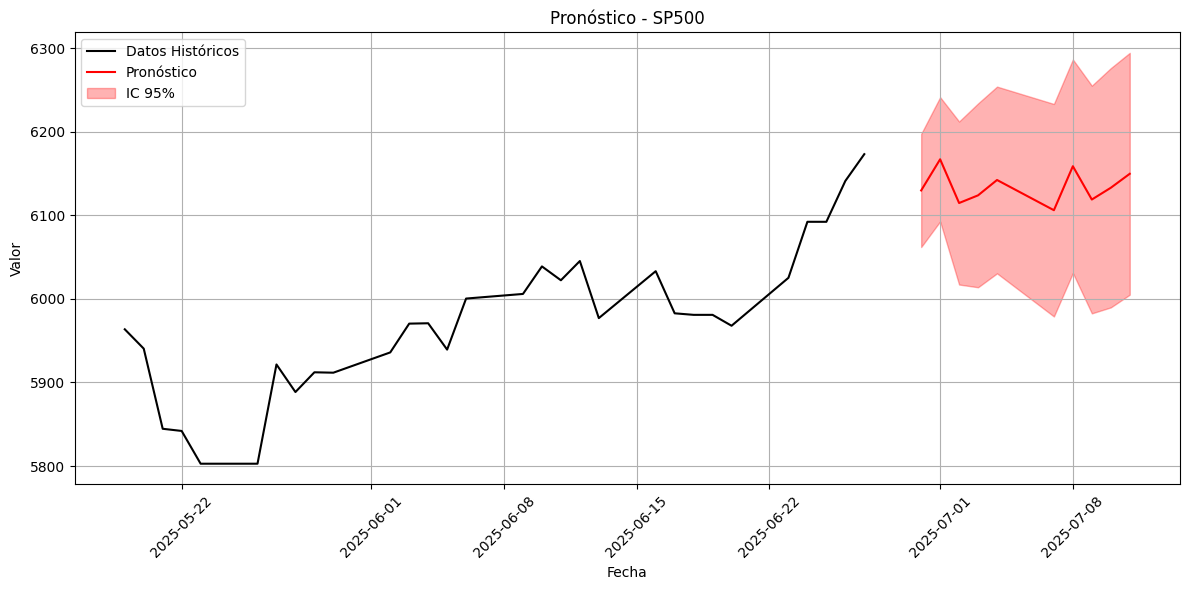

Pronóstico para SP500:
2025-06-30    6129.659701
2025-07-01    6166.945526
2025-07-02    6114.637824
2025-07-03    6123.819034
2025-07-04    6142.190000
2025-07-07    6106.031075
2025-07-08    6158.657484
2025-07-09    6118.803220
2025-07-10    6132.869149
2025-07-11    6149.598986
Freq: B, Name: predicted_mean, dtype: float64

🔍 Pronosticando para Spread_10y_2y


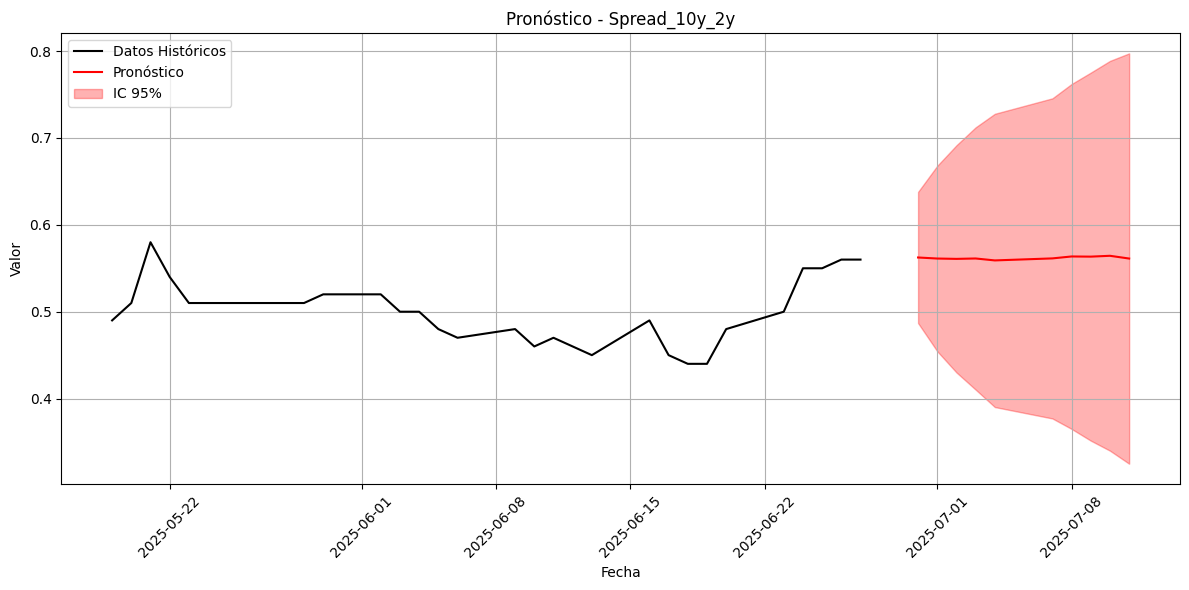

Pronóstico para Spread_10y_2y:
2025-06-30    0.562415
2025-07-01    0.561217
2025-07-02    0.560822
2025-07-03    0.561275
2025-07-04    0.559047
2025-07-07    0.561372
2025-07-08    0.563596
2025-07-09    0.563403
2025-07-10    0.564370
2025-07-11    0.561205
Freq: B, Name: predicted_mean, dtype: float64

🔍 Pronosticando para VIX


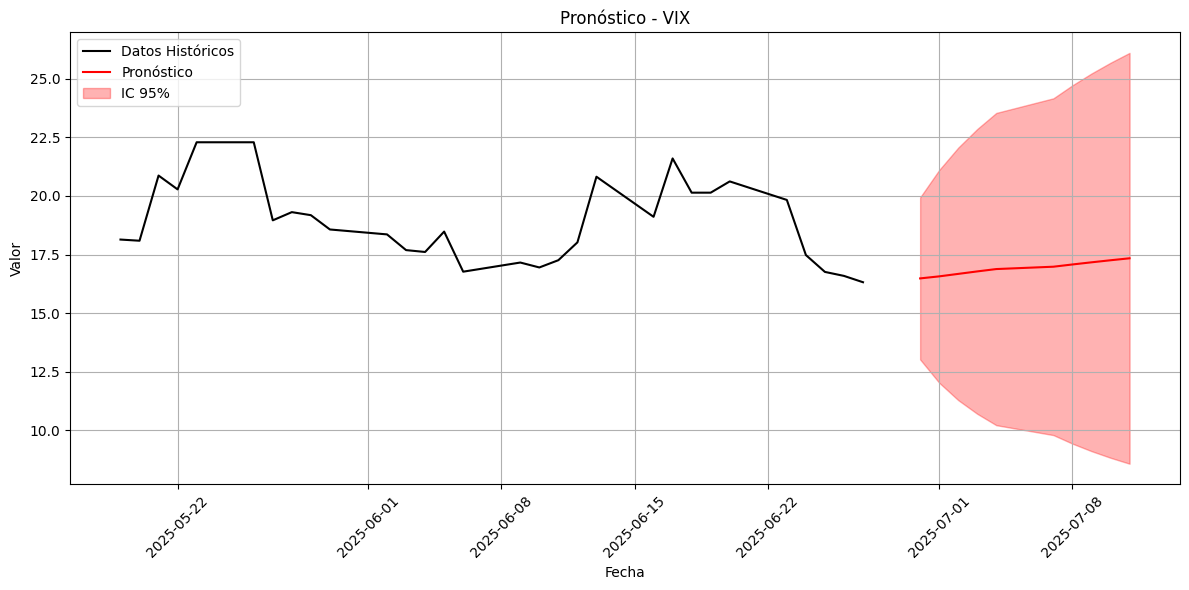

Pronóstico para VIX:
2025-06-30    16.483116
2025-07-01    16.569873
2025-07-02    16.675613
2025-07-03    16.781354
2025-07-04    16.881529
2025-07-07    16.981957
2025-07-08    17.077574
2025-07-09    17.169195
2025-07-10    17.256915
2025-07-11    17.340909
Freq: B, Name: predicted_mean, dtype: float64


In [ ]:
# Función para pronosticar
def pronosticar_serie(serie, order, seasonal_order, nombre="Serie", horizon=horizon):
    print(f"\n🔍 Pronosticando para {nombre}")
    try:
        # Ajustar el modelo a toda la serie
        modelo = SARIMAX(serie.dropna(), order=order,
                         seasonal_order=seasonal_order,
                         enforce_stationarity=True, enforce_invertibility=True)
        resultado = modelo.fit(disp=False, maxiter=100)

        # Pronóstico para la ventana temporal (horizon días hábiles)
        pronostico = resultado.forecast(steps=horizon)
        indice_futuro = pd.date_range(start=serie.index[-1] + pd.offsets.BDay(1),
                                      periods=horizon, freq='B')
        pronostico = pd.Series(pronostico, index=indice_futuro)

        # Graficamos los últimos 3*horizon puntos
        serie_plot = serie.dropna().iloc[-3 * horizon:]  # Últimos 3 * horizon puntos

        # Gráfico con intervalos de confianza
        plt.figure(figsize=(12, 6))
        plt.plot(serie_plot.index, serie_plot.values, label='Datos Históricos', color='black')

        # Obtener predicción con IC
        pred_res = resultado.get_forecast(steps=horizon)
        pred_mean = pred_res.predicted_mean
        pred_ci = pred_res.conf_int(alpha=0.05)

        plt.plot(pred_mean.index, pred_mean.values, label='Pronóstico', color='red')
        plt.fill_between(pred_ci.index,
                         pred_ci.iloc[:, 0],
                         pred_ci.iloc[:, 1],
                         color='red', alpha=0.3, label='IC 95%')

        plt.title(f"Pronóstico - {nombre}")
        plt.xlabel("Fecha")
        plt.ylabel("Valor")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Imprimir valores del pronóstico
        print(f"Pronóstico para {nombre}:")
        print(pronostico)

    except Exception as e:
        print(f"Error al pronosticar {nombre}: {e}")

# Ejecutar pronósticos para cada serie
for col, params in series_a_analizar.items():
    pronosticar_serie(series[col], params['order'], params['seasonal_order'], nombre=col)

## CONSTRUCCION DE MODELO SARIMAX

###### La serie a pronosticar será la Spread10y_2y original, dada su no estacionariedad deberemos aplicar un nivel de diferenciación en la ejecución del modelo.

##### Como variables exógenas regresora, utilizaremos la serie VIX y SP500 dada su relación económica con los bonos a 10 y 2 años.

##### A su vez, se probarán dos criterios en la construcción del SARIMAX:


*   Diferenciando ambas variables regresoras
*   Diferenciando sólamente SP500



In [ ]:
# ## Definimos el modelo SARIMAX a entrenar, buscamos los mejores parámetros con gridsearch.  ## Comentado dado que los mejores hiperparámetros fueron hallados

def sarimax_grid_search(
    y,
    X,
    p_range=[0, 1, 2],
    d_range=[1],              # Spread no es estacionario → d=1
    q_range=[0, 1, 2],
    P_range=[0, 1, 2],
    D_range=[0, 1],
    Q_range=[0, 1, 2],
    s_range=[0, 5, 22, 261],
    debug=False
):
    """
    Grid-search SARIMAX(p,d,q)x(P,D,Q,s) con exógenas.

    Parámetros extra:
        X (pd.DataFrame/Series): matriz de variables exógenas alineada con y.

    Devuelve:
        best_model : objeto SARIMAXResults.
        results_df : DataFrame con 'order', 'seasonal_order', 'aic', 'bic', 'llf'.
    """
    # 1) Todas las combinaciones válidas
    configs = [
        (p, d, q, P, D, Q, s)
        for p, d, q in itertools.product(p_range, d_range, q_range)
        for P, D, Q in itertools.product(P_range, D_range, Q_range)
        for s in s_range
        if not (s == 0 and any([P, D, Q]))
    ]

    records  = []
    iterator = configs if debug else tqdm(
        configs, desc="Grid Search SARIMAX", total=len(configs), unit="cfg"
    )

    # 2) Iterar sin retener modelos intermedios
    for p, d, q, P, D, Q, s in iterator:
        order, seas_order = (p, d, q), (P, D, Q, s)

        if debug:
            print(f"Probando SARIMAX(order={order}, seasonal={seas_order})")

        try:
            model = SARIMAX(
                y,
                exog=X,
                order=order,
                seasonal_order=seas_order,
                enforce_stationarity=True,
                enforce_invertibility=True,
            )
            res = model.fit(disp=False)

            records.append(
                {
                    "order": order,
                    "seasonal_order": seas_order,
                    "aic": res.aic,
                    "bic": res.bic,
                    "llf": res.llf,
                }
            )

            if debug:
                print(f"  -> AIC={res.aic:.2f}, BIC={res.bic:.2f}")

        except Exception as e:
            if debug:
                print(f"  ❌ Error: {e}")

        finally:
            # liberamos memoria
            for obj in ("res", "model"):
                try:
                    del globals()[obj]
                except KeyError:
                    pass
            gc.collect()

    # 3) DataFrame de resultados
    results_df = pd.DataFrame(records)
    if results_df.empty:
        raise ValueError("No se ajustó ningún SARIMAX; revise parámetros/datos.")

    results_df = results_df.sort_values("aic").reset_index(drop=True)
    best_cfg   = results_df.loc[0]

    # 4) Re‐ajustar SOLO el mejor modelo una vez
    best_model = SARIMAX(
        y,
        exog=X,
        order=best_cfg["order"],
        seasonal_order=best_cfg["seasonal_order"],
        enforce_stationarity=True,
        enforce_invertibility=True,
    ).fit(disp=False)
    gc.collect()

    return best_model, results_df

In [ ]:
### Probamos particiones distintas de train y test

# Didividmos en training y test dejando spread10y_2y sin diferenciar, y las regresoras diferenciando SP500 y VIX

# Diff VIX
VIX_diff = series[['VIX']].copy()
VIX_diff["valor_diff"] = VIX_diff["VIX"].diff().dropna()

VIX_diff = VIX_diff.drop('2000-01-03')
VIX_diff = VIX_diff['valor_diff']
VIX_diff.head()

Spread_10y_2y_d = series[['Spread_10y_2y']].copy()
Spread_10y_2y_d = Spread_10y_2y_d.drop('2000-01-03')

#Arma el concatenado de series totalmente diferenciadas

series_diff2 = pd.concat([Spread_10y_2y_d, SP500_diff, VIX_diff], axis=1, join='outer')
series_diff2.columns = ['Spread_10y_2y_d', 'SP500_diff', 'VIX_diff']

print(series_diff2.head(30))


            Spread_10y_2y_d  SP500_diff  VIX_diff
Fecha                                            
2000-01-04             0.19  -55.799927  2.800001
2000-01-05             0.24    2.689941 -0.600000
2000-01-06             0.22    1.339966 -0.680000
2000-01-07             0.21   38.020020 -4.010000
2000-01-10             0.19   16.130005 -0.010000
2000-01-11             0.22  -19.039917  0.790001
2000-01-12             0.23   -6.310059  0.340000
2000-01-13             0.23   17.430054 -1.130001
2000-01-14             0.25   15.469971 -2.049999
2000-01-17             0.25    0.000000  0.000000
2000-01-18             0.28  -10.010010  1.840000
2000-01-19             0.27    0.760010  0.219999
2000-01-20             0.30  -10.330078  0.030001
2000-01-21             0.31   -4.209961 -0.930000
2000-01-24             0.26  -39.829956  3.250000
2000-01-25             0.26    8.500000 -1.049999
2000-01-26             0.24   -5.940063  0.010000
2000-01-27             0.17   -5.529907  0.510000


In [ ]:
# Didividmos en training y test dejando spread10y_2y sin diferenciar, y las regresoras diferenciando SP500 y VIX sin diferenciar

#Arma el concatenado de series totalmente diferenciadas

series_diff3 = pd.concat([Spread_10y_2y_d, SP500_diff, series[['VIX']]], axis=1, join='outer')
series_diff3.columns = ['Spread_10y_2y_d', 'SP500_diff', 'VIX']
series_diff3 = series_diff3.drop(index='2000-01-03')
print(series_diff3.head(30))

            Spread_10y_2y_d  SP500_diff        VIX
Fecha                                             
2000-01-04             0.19  -55.799927  27.010000
2000-01-05             0.24    2.689941  26.410000
2000-01-06             0.22    1.339966  25.730000
2000-01-07             0.21   38.020020  21.719999
2000-01-10             0.19   16.130005  21.709999
2000-01-11             0.22  -19.039917  22.500000
2000-01-12             0.23   -6.310059  22.840000
2000-01-13             0.23   17.430054  21.709999
2000-01-14             0.25   15.469971  19.660000
2000-01-17             0.25    0.000000  19.660000
2000-01-18             0.28  -10.010010  21.500000
2000-01-19             0.27    0.760010  21.719999
2000-01-20             0.30  -10.330078  21.750000
2000-01-21             0.31   -4.209961  20.820000
2000-01-24             0.26  -39.829956  24.070000
2000-01-25             0.26    8.500000  23.020000
2000-01-26             0.24   -5.940063  23.030001
2000-01-27             0.17   -

In [ ]:
## Spliteamos en train y test los conjuntos de series:

# # Didividmos en training y test para series_diff2
seriesd2_train = series_diff2.iloc[:-horizon]
seriesd2_test = series_diff2.iloc[-horizon:]


# Didividmos en training y test para series_diff3
seriesd3_train = series_diff3.iloc[:-horizon]
seriesd3_test = series_diff3.iloc[-horizon:]

In [ ]:
## Comentada, dado que corresponde a un testeo de otro modelo que no fue utilizado
y_train2 = y_train.copy()
y_train2 = y_train2.drop('2000-01-03')
y_train2.head()

,VIX
Fecha,
2000-01-04,27.010000
2000-01-05,26.410000
2000-01-06,25.730000
2000-01-07,21.719999
2000-01-10,21.709999


In [ ]:
y_test.head()

,VIX
Fecha,
2025-06-16,19.110001
2025-06-17,21.600000
2025-06-18,20.139999
2025-06-19,20.139999
2025-06-20,20.620001


In [ ]:
## Definición de series a utilizar

# Objetivo_diff2
# y_train2 = seriesd2_train['Spread_10y_2y_d'].dropna()
# y_test2  = seriesd2_test['Spread_10y_2y_d'].dropna()

# # Variables exógenas diff2
# X_train2 = seriesd2_train[['VIX_diff', 'SP500_diff']].loc[y_train2.index]
# X_test2  = seriesd2_test[['VIX_diff', 'SP500_diff']].loc[y_test.index]

# Objetivo_diff3  #Esta es la opción elegida
y_train3 = seriesd3_train['Spread_10y_2y_d'].dropna()
y_test3  = seriesd3_test['Spread_10y_2y_d'].dropna()

# Variables exógenas diff3
X_train3 = seriesd3_train[['VIX', 'SP500_diff']].loc[y_train2.index]
X_test3  = seriesd3_test[['VIX', 'SP500_diff']].loc[y_test.index]


In [ ]:
# ### Aplicamos el SARIMAX Elegido a las series Spread10y_2y y VIX diff + SP500 diff. Comentado, dado que fue un modelo rechazado

# best_model, grid_df = sarimax_grid_search(
#     y_train2,
#     X_train2,
#     p_range=[0, 1, 2],
#     d_range=[1],     # Spread no es estacionario
#     q_range=[0, 1, 2],
#     P_range=[0, 1, 2],
#     D_range=[0, 1],
#     Q_range=[0, 1, 2],
#     s_range=[0, 5],
#     debug=False
# )

Grid Search SARIMAX: 100%|██████████| 171/171 [53:47<00:00, 18.87s/cfg]


In [ ]:
### EVALUACIÓN FUERA DE MUESTRA para Spread10y_2y con SP500diff y VIXdiff   --Comentado, dado que fue un modelo rechazado

# grid_df['rmse'] = np.nan
# grid_df['mae']  = np.nan

# print("⏳ Evaluando modelos fuera de muestra...")
# for i, row in tqdm(grid_df.iterrows(), total=len(grid_df), desc="Evaluación RMSE/MAE"):
#     try:
#         model_test = SARIMAX(
#             y_train2, exog=X_train2,
#             order=row['order'],
#             seasonal_order=row['seasonal_order'],
#             enforce_stationarity=True,
#             enforce_invertibility=True,
#         ).fit(disp=False)

#         pred = model_test.get_forecast(
#             steps=len(y_test2), exog=X_test2
#         ).predicted_mean

#         grid_df.loc[i, 'rmse'] = np.sqrt(mean_squared_error(y_test2, pred))
#         grid_df.loc[i, 'mae']  = mean_absolute_error(y_test2, pred)

#     except Exception as e:
#         continue

# # -------------------------------------
# # 5. RANKING FINAL
# # -------------------------------------

# print("✅ Evaluación finalizada. Mejores modelos para sp500DIFF y VIXDIFF:")

# grid_df = grid_df.sort_values(['aic']).reset_index(drop=True)
# display(grid_df[['order','seasonal_order','aic','bic','rmse','mae']].head())

# grid_df.to_csv("resultados_search_grid_SARIMAX1.csv", index=False)

⏳ Evaluando modelos fuera de muestra...


Evaluación RMSE/MAE: 100%|██████████| 171/171 [50:26<00:00, 17.70s/it]

✅ Evaluación finalizada. Mejores modelos para sp500DIFF y VIXDIFF:


,order,seasonal_order,aic,bic,rmse,mae
0,"(0, 1, 0)","(2, 0, 1, 5)",-24413.698432,-24372.895036,0.068019,0.054517
1,"(0, 1, 0)","(1, 0, 2, 5)",-24413.106085,-24372.302689,0.068232,0.054614
2,"(0, 1, 0)","(2, 0, 2, 5)",-24412.368303,-24364.764341,0.068342,0.054656
3,"(1, 1, 0)","(2, 0, 1, 5)",-24412.319759,-24364.715797,0.068084,0.054555
4,"(0, 1, 1)","(2, 0, 1, 5)",-24412.305939,-24364.701977,0.068098,0.054565


In [ ]:
## Grid search del modelo elegido. Comentado dado que se lo entrena con los hiperparámetros hallados.
# ### Aplicamos el SARIMAX Elegido a las series Spread10y_2y y VIX + SP500 diff


# best_model1, grid_df1 = sarimax_grid_search(
#     y_train3,
#     X_train3,
#     p_range=[0, 1, 2],
#     d_range=[1],     # Spread no es estacionario
#     q_range=[0, 1, 2],
#     P_range=[0, 1, 2],
#     D_range=[0, 1],
#     Q_range=[0, 1, 2],
#     s_range=[0, 5],
#     debug=False
# )

Grid Search SARIMAX: 100%|██████████| 171/171 [59:29<00:00, 20.88s/cfg]


In [ ]:
### EVALUACIÓN FUERA DE MUESTRA para Spread10y_2y con SP500diff y VIX que fue el modelo elegido. Comentado dado que no se utiliza el gridsearch

# grid_df1['rmse'] = np.nan
# grid_df1['mae']  = np.nan

# print("⏳ Evaluando modelos fuera de muestra...")
# for i, row in tqdm(grid_df1.iterrows(), total=len(grid_df1), desc="Evaluación RMSE/MAE"):
#     try:
#         model_test = SARIMAX(
#             y_train3, exog=X_train3,
#             order=row['order'],
#             seasonal_order=row['seasonal_order'],
#             enforce_stationarity=True,
#             enforce_invertibility=True,
#         ).fit(disp=False)

#         pred = model_test.get_forecast(
#             steps=len(y_test3), exog=X_test3
#         ).predicted_mean

#         grid_df1.loc[i, 'rmse'] = np.sqrt(mean_squared_error(y_test3, pred))
#         grid_df1.loc[i, 'mae']  = mean_absolute_error(y_test3, pred)

#     except Exception as e:
#         continue

# # -------------------------------------
# # 5. RANKING FINAL
# # -------------------------------------

# print("✅ Evaluación finalizada. Mejores modelos para SP500diff y VIX:")

# grid_df1 = grid_df1.sort_values(['aic']).reset_index(drop=True)
# display(grid_df1[['order','seasonal_order','aic','bic','rmse','mae']].head())

# grid_df1.to_csv("resultados_search_grid_SARIMAX2.csv", index=False)

### Selección del modelo SARIMAX
El modelo seleccionado fue un SARIMAX con orden no estacional
(
0
,
1
,
0
)
(0,1,0) y orden estacional
(
2
,
0
,
1
)
(2,0,1) con periodicidad semanal (
𝑠
=
5
s=5).
Este modelo se ajustó sobre la serie del spread 10y-2y con dos variables exógenas: el índice SP500 diferenciado y el VIX sin diferenciar.
Se obtuvo un AIC = -24414.77, con un RMSE fuera de muestra de 0.0669 y MAE de 0.0537, siendo el mejor balance entre complejidad y precisión del conjunto evaluado.

## Entrenamos el modelo SARIMAX elegido, con los hiperparámetros encontrados con el GridSearch.

Luego, se realizan las predicciones correspondientes con sus gráficas.

RMSE: 0.0669
MAE : 0.0537


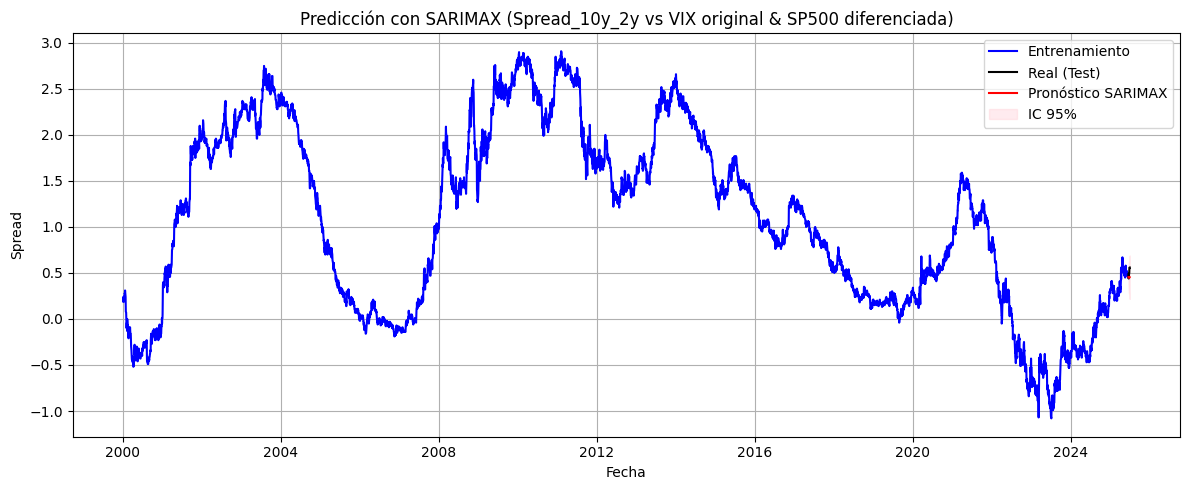

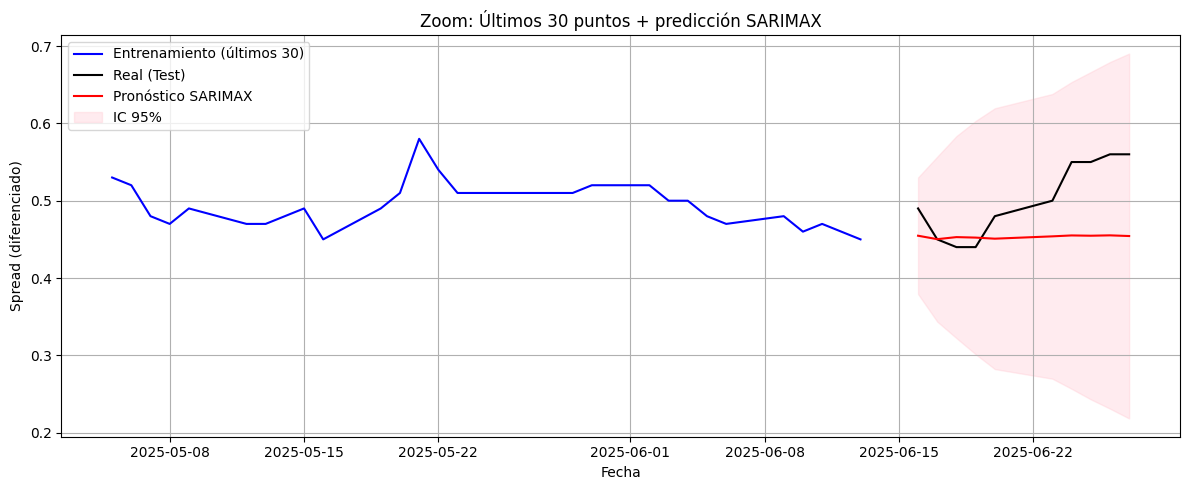

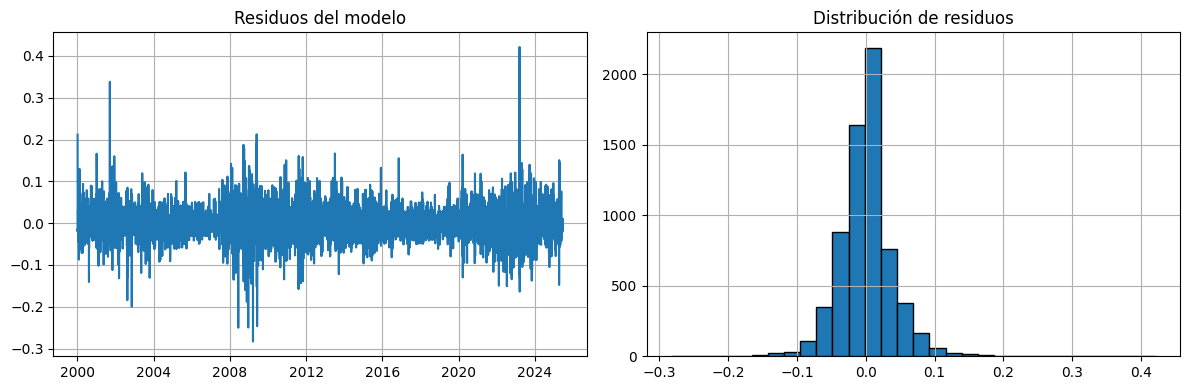

In [ ]:
# -----------------------------------------------
# BLOQUE 1: Entrenamiento, pronóstico y análisis SARIMAX
# Spread_10y_2y_d ~ VIX + SP500_diff
# -----------------------------------------------

# ------------------------
# ENTRENAMIENTO
# ------------------------
final_model = SARIMAX(
    y_train3,
    exog=X_train3,
    order=sarimax_best_order,
    seasonal_order=sarimax_best_seasonal_order,
    enforce_stationarity=True,
    enforce_invertibility=True
).fit(disp=False)

# ------------------------
# PRONÓSTICO
# ------------------------
forecast = final_model.get_forecast(steps=len(y_test3), exog=X_test3)
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

# ------------------------
# MÉTRICAS
# ------------------------
rmse = np.sqrt(mean_squared_error(y_test3, pred))
mae = mean_absolute_error(y_test3, pred)
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")

# ------------------------
# GRÁFICO DEL PRONÓSTICO
# ------------------------
plt.figure(figsize=(12, 5))
plt.plot(y_train3.index, y_train3, label='Entrenamiento', color='blue')
plt.plot(y_test3.index, y_test3, label='Real (Test)', color='black')
plt.plot(y_test3.index, pred, label='Pronóstico SARIMAX', color='red')
plt.fill_between(y_test3.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='IC 95%')
plt.xlabel('Fecha')
plt.ylabel('Spread')
plt.title('Predicción con SARIMAX (Spread_10y_2y vs VIX original & SP500 diferenciada)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Zoom: últimas 30 observaciones + predicción ---
n_train_to_plot = 30
train_subset = y_train3[-n_train_to_plot:]

plt.figure(figsize=(12, 5))
plt.plot(train_subset.index, train_subset.values, label='Entrenamiento (últimos 30)', color='blue')
plt.plot(y_test3.index, y_test3.values, label='Real (Test)', color='black')
plt.plot(y_test3.index, pred.values, label='Pronóstico SARIMAX', color='red')
plt.fill_between(y_test3.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='IC 95%')
plt.title('Zoom: Últimos 30 puntos + predicción SARIMAX')
plt.xlabel('Fecha')
plt.ylabel('Spread (diferenciado)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# =========================
#  DIAGNÓSTICO DE RESIDUOS
# =========================
residuals = final_model.resid

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(residuals)
axes[0].set_title("Residuos del modelo")
axes[0].grid(True)

axes[1].hist(residuals, bins=30, edgecolor='black')
axes[1].set_title("Distribución de residuos")
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Comparación SARIMAX elegido vs. SARIMA óptimo entrenado
A continuación se realiza la comparación del poder predictivo entre ambos modelos.

Para esto, se ejecuta el SARIMA sobre la misma población analizada por SARIMAX.

📊 Comparación de Métricas (Test)
SARIMA  RMSE: 0.0612 | MAE: 0.0515
SARIMAX RMSE: 0.0669 | MAE: 0.0537


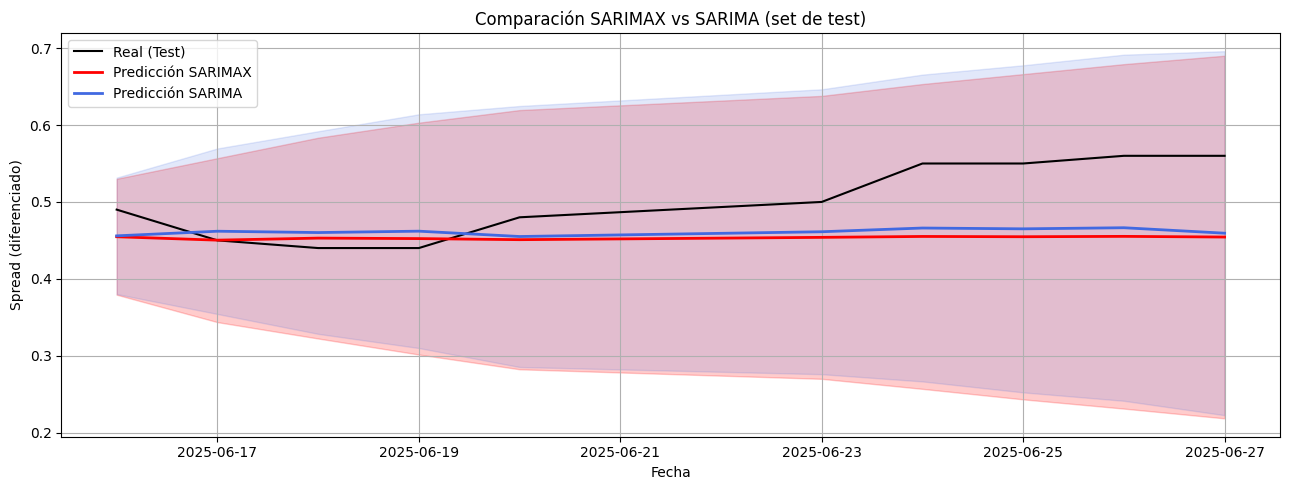

In [ ]:

# =================================================
# 1. ENTRENAR el SARIMA óptimo SIN regresoras
#    (parámetros tomados de sarima_models_params)
# =================================================
sarima_order          = (2, 0, 1)
sarima_seasonal_order = (2, 1, 1, 5)

sarima_model = SARIMAX(
    y_train3,                      # objetivo
    order=sarima_order,
    seasonal_order=sarima_seasonal_order,
    enforce_stationarity=True,
    enforce_invertibility=True
).fit(disp=False)

# =================================================
# 2. PRONÓSTICO sobre el mismo set de test
# =================================================
sarima_fc   = sarima_model.get_forecast(steps=len(y_test3))
sarima_pred = sarima_fc.predicted_mean
sarima_ci   = sarima_fc.conf_int()

# =================================================
# 3. MÉTRICAS comparativas
# =================================================
sarima_rmse = np.sqrt(mean_squared_error(y_test3, sarima_pred))
sarima_mae  = mean_absolute_error(y_test3, sarima_pred)

print("📊 Comparación de Métricas (Test)")
print(f"SARIMA  RMSE: {sarima_rmse:.4f} | MAE: {sarima_mae:.4f}")
print(f"SARIMAX RMSE: {rmse:.4f} | MAE: {mae:.4f}")        # rmse/mae ya calculados en Bloque 1

# =================================================
# 4. GRÁFICO COMPARATIVO sobre el TEST
# =================================================
plt.figure(figsize=(13,5))

# Serie real
plt.plot(y_test3.index, y_test3.values, label='Real (Test)', color='black')

# SARIMAX
plt.plot(y_test3.index, pred.values, label='Predicción SARIMAX', color='red', lw=2)
plt.fill_between(y_test3.index, conf_int.iloc[:,0], conf_int.iloc[:,1],
                 color='red', alpha=0.20)

# SARIMA
plt.plot(y_test3.index, sarima_pred.values, label='Predicción SARIMA', color='royalblue', lw=2)
plt.fill_between(y_test3.index, sarima_ci.iloc[:,0], sarima_ci.iloc[:,1],
                 color='royalblue', alpha=0.15)

plt.title('Comparación SARIMAX vs SARIMA (set de test)')
plt.xlabel('Fecha')
plt.ylabel('Spread (diferenciado)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Test HEGY para raices unitarias

#### El test de HEGY (Hylleberg, Engle, Granger, Yoo, 1990) es una prueba de raíz unitaria estacional diseñada específicamente para series temporales con estacionalidad. A diferencia de las pruebas estándar como ADF o KPSS, que testean raíces unitarias en

𝑧
𝑡
=
𝑧
𝑡
−
1
+
𝜖
𝑡
z
t
​
 =z
t−1
​
 +ϵ
t
​


 HEGY permite testear raíces unitarias en diferentes frecuencias estacionales, como la raíz unitaria en el componente anual, trimestral, mensual, etc.

Es decir, permite determinar si una serie tiene componente estacional no estacionario (una raíz unitaria en la parte estacional).

In [ ]:
spread_series = series["Spread_10y_2y"].dropna()

In [ ]:
## Cargamos librerías en el entorno de R

%%R

library(urca)
library(uroot)

In [ ]:
### Enviamos la info de la serie desde python al entorno R


# spread_series debe ser un pd.Series con índice DateTime y sin NA
%%R -i spread_series

NULL


#### Para realizar el test de HEGY, le pasamos una estacionalidad semanal basada en 5 días hábiles, que es la que más se aproxima a la forma de la serie spread_10y_2y

In [ ]:

%%R
library(uroot)

# Convertimos a objeto ts con frecuencia semanal (5 días hábiles por semana)
spread_series_ts <- ts(spread_series, frequency = 5)

# Aplicamos el test HEGY clásico a la serie
hegy_res <- hegy.test(spread_series_ts, lag.method = "AIC", maxlag = 10)
summary(hegy_res)


	HEGY test for unit roots

data:  spread_series_ts

Fitted model
------------

Call:
lm(formula = dx ~ 0 + ypi + xreg)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.28019 -0.02054 -0.00056  0.01976  0.41257 

Coefficients:
           Estimate Std. Error t value Pr(>|t|)    
ypiYpi1  -0.0001537  0.0000967  -1.589    0.112    
ypiYpi2  -0.2749418  0.0106724 -25.762   <2e-16 ***
ypiYpi3  -0.3934650  0.0092467 -42.552   <2e-16 ***
ypiYpi4  -0.7303910  0.0158372 -46.119   <2e-16 ***
ypiYpi5  -0.2228882  0.0167133 -13.336   <2e-16 ***
xregc     0.0008780  0.0007016   1.251    0.211    
xregLag1 -0.0027043  0.0174287  -0.155    0.877    
xregLag2 -0.0193984  0.0122740  -1.580    0.114    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03851 on 6635 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.8007,	Adjusted R-squared:  0.8005 
F-statistic:  3332 on 8 and 6635 DF,  p-value: < 2.2e-16

Tes

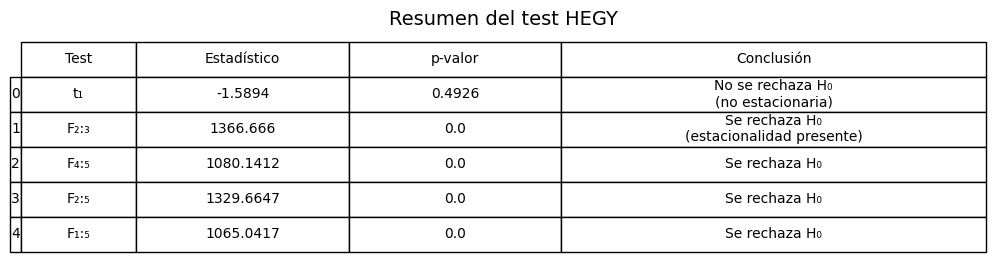

In [ ]:
## Vuelca los resultados del HEGY de forma manual
# Datos con saltos de línea
hegy_summary = pd.DataFrame({
    "Test": ["t₁", "F₂:₃", "F₄:₅", "F₂:₅", "F₁:₅"],
    "Estadístico": [-1.5894, 1366.666, 1080.1412, 1329.6647, 1065.0417],
    "p-valor": [0.4926, 0.0000, 0.0000, 0.0000, 0.0000],
    "Conclusión": [
        "No se rechaza H₀\n(no estacionaria)",
        "Se rechaza H₀\n(estacionalidad presente)",
        "Se rechaza H₀",
        "Se rechaza H₀",
        "Se rechaza H₀"
    ]
})

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(10, 2.8))  # Aumentamos el alto de la figura
ax.axis('off')

# Insertar tabla
tbl = table(ax, hegy_summary, loc='center', cellLoc='center', colWidths=[0.12, 0.22, 0.22, 0.44])

# Ajustes estéticos
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 2.0)  # Escalamos alto de fila (2.0) y ancho de columna (1.2)

# Título
plt.title("Resumen del test HEGY", fontsize=14)
plt.tight_layout()
plt.show()